In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Finance Stocks CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['FBP','AFG','JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2019-01-22         9.50  9.028269  -2.255619  11013900.0     2.0
2019-01-23         9.40  9.085459 -15.384672   9894000.0     2.0
2019-01-24         9.41  9.135388 -14.615424  11127300.0     2.0
2019-01-25         9.64  9.213021  -0.854639  12071100.0     2.0
2019-01-28         9.74  9.294094  -9.599991  13124000.0     2.0
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    95.959999  92.750365  -1.891883  2019300.0     2.0
2019-01-23    95.279999  93.139539 -17.336730  1754000.0     2.0
2019-01-24    95.690002  93.531918 -12.247481  2036400.0     2.0
2019-01-25    95.019997  93.760853 -21.494180  1640100.0     2.0
2019-01-28    94.750000  93.913030 -25.032797  1462200.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                   

In [9]:
r_test_sets = ['FBP','AFG','JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22        10.16  10.378210 -80.303008 -2725500.0     2.0
2020-01-23        10.12  10.338485 -84.615464 -4799800.0     2.0
2020-01-24        10.17  10.312565 -73.770502 -3020800.0     2.0
2020-01-27        10.01  10.266016 -83.561649 -4665400.0     2.0
2020-01-28         9.87  10.205091 -87.209337 -6089900.0     2.0
            previous_1d      EMA_12   willr_14     OBV_7  labels
Date                                                            
2020-01-22   110.709999  110.318220 -37.234155  495600.0     2.0
2020-01-23   110.660004  110.370802 -39.007042   43700.0     2.0
2020-01-24   110.239998  110.350678 -53.900867 -231100.0     2.0
2020-01-27   110.489998  110.372112 -45.035617   27900.0     1.0
2020-01-28   108.529999  110.088710 -98.475749 -331600.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                   

## Train First BanCorp Stock Data

### Creating Training Data and Model

            previous_1d      EMA_12  willr_14    OBV_7  labels
Date                                                          
2000-01-21     100.0000  100.813609     -64.0 -21460.0     2.0
2000-01-24      97.1875  100.255746    -100.0 -28200.0     2.0
2000-01-25      96.2500   99.639478    -100.0 -32420.0     2.0
2000-01-26      93.1250   98.637250    -100.0 -42580.0     2.0
2000-01-27      94.0625   97.933443     -90.0 -36840.0     2.0


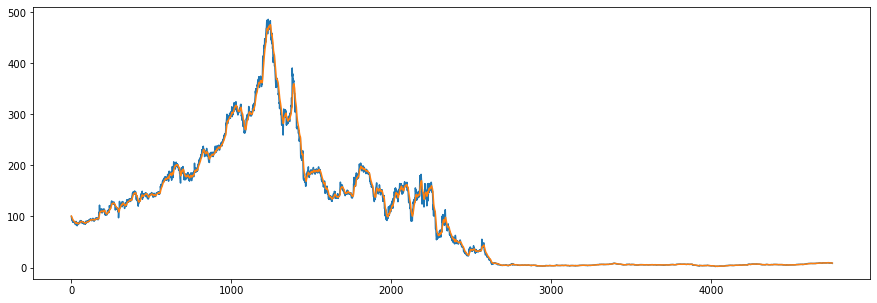

(4745, 64, 64, 1)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/FBP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4313, 1.0: 216, 0.0: 216})

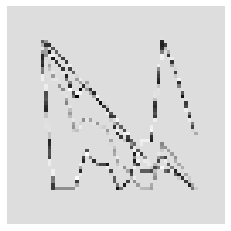

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'FirstBanCorpModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'FirstBanCorpModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3140655105973025, 1: 7.3140655105973025, 2: 0.36676328502415456}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3643 - accuracy: 0.7109 - mse: 5.5269 - weighted_accuracy: 0.4395 - weighted_mse: 5.2575WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 24ms/step - loss: 0.2425 - accuracy: 0.3001 - mse: 1.6672 - weighted_accuracy: 0.3223 - weighted_mse: 1.6385 - val_loss: 0.2284 - val_accuracy: 0.0464 - val_mse: 0.8322 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.8322
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2064 - accuracy: 0.2745 - mse: 1.1962 - weighted_accuracy: 0.3404 - weighted_mse: 1.1836 - val_loss: 0.203

7/7 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.5297 - mse: 0.9265 - weighted_accuracy: 0.5297 - weighted_mse: 0.9265
Test loss: 0.19131304323673248
Test accuracy: 0.5296803712844849


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 63
actual holds but predicted sell: 25
actual predicted holds: 109
Percentage buys correct: 5.797101449275362%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 90.08264462809917%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 49.27536231884058%
Percentage high sells correct: 48.275862068965516%
Percentage mid holds correct: 85.83333333333333%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.4795 - mse: 0.9256 - weighted_accuracy: 0.4795 - weighted_mse: 0.9256
Test loss: 0.191619873046875
Test accuracy: 0.4794520437717438


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 63
actual holds but predicted sell: 37
actual predicted holds: 97
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 88.9908256880734%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 42.64705882352941%
Percentage high sells correct: 54.76190476190476%
Percentage mid holds correct: 84.25925925925925%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Price in

7/7 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.5160 - mse: 0.9262 - weighted_accuracy: 0.5160 - weighted_mse: 0.9262
Test loss: 0.19131875038146973
Test accuracy: 0.5159817337989807


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 5
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 57
actual holds but predicted sell: 37
actual predicted holds: 103
Percentage buys correct: 7.462686567164179%
Percentage sells correct: 11.904761904761905%
Percentage holds correct: 93.63636363636364%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.96969696969697%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 84.54545454545455%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price 

30/30 [==============================] - 0s 10ms/step - loss: 0.1929 - accuracy: 0.2935 - mse: 1.1971 - weighted_accuracy: 0.4188 - weighted_mse: 1.1929 - val_loss: 0.1895 - val_accuracy: 0.3151 - val_mse: 1.0064 - val_weighted_accuracy: 0.3151 - val_weighted_mse: 1.0064
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1928 - accuracy: 0.2929 - mse: 1.1975 - weighted_accuracy: 0.4094 - weighted_mse: 1.1878 - val_loss: 0.1943 - val_accuracy: 0.1623 - val_mse: 0.9603 - val_weighted_accuracy: 0.1623 - val_weighted_mse: 0.9603
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1946 - accuracy: 0.2998 - mse: 1.1992 - weighted_accuracy: 0.4009 - weighted_mse: 1.1720 - val_loss: 0.1959 - val_accuracy: 0.0759 - val_mse: 1.0176 - val_weighted_accuracy: 0.0759 - val_weighted_mse: 1.0176
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1919 - accuracy: 0.2737 - mse: 1.2024 - weighted_accuracy: 0.4262 - weighted_mse: 1.185

7/7 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.2064 - mse: 1.0136 - weighted_accuracy: 0.2064 - weighted_mse: 1.0136
Test loss: 0.19154015183448792
Test accuracy: 0.20642201602458954


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 81
actual holds but predicted sell: 80
actual predicted holds: 36
Percentage buys correct: 5.4945054945054945%
Percentage sells correct: 4.597701149425287%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 41.86046511627907%
Percentage mid holds correct: 82.5%


Capital: 100
Share price: $0.3201633590364861
Shares owned at the moment: 311
Cash capital at the moment: $0.15537562683687156


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.2661 - mse: 1.0147 - weighted_accuracy: 0.2661 - weighted_mse: 1.0147
Test loss: 0.19109246134757996
Test accuracy: 0.26605504751205444


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 67
actual predicted holds: 47
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 94.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 44.791666666666664%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 81.63265306122449%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previous

Cash capital at the moment: $85.18131508375913


Share price: $0.34101583633014876
Shares owned at the moment: 249
Cash capital at the moment: $0.034861243625016414


Price increase from previously bought: 7.8586522865858655%
Share price: $0.3688265766336891
Shares owned at the moment: 0
Cash capital at the moment: $91.62012482706368


Share price: $0.40749028245190155
Shares owned at the moment: 224
Cash capital at the moment: $0.09128754384735771


Price increase from previously bought: -13.513086375866745%
Share price: $0.3533949394745928
Shares owned at the moment: 0
Cash capital at the moment: $79.03406270343979


Share price: $0.33762420374584257
Shares owned at the moment: 233
Cash capital at the moment: $0.15129052210831162


Price increase from previously bought: 3.181909460378618%
Share price: $0.3493251097509793
Shares owned at the moment: 0
Cash capital at the moment: $81.32021103001355


Share price: $0.3912108341798941
Shares owned at the moment: 207
Cash capital at the m

30/30 [==============================] - 0s 9ms/step - loss: 0.1819 - accuracy: 0.2134 - mse: 1.2585 - weighted_accuracy: 0.4791 - weighted_mse: 1.2224 - val_loss: 0.1923 - val_accuracy: 0.1918 - val_mse: 1.0559 - val_weighted_accuracy: 0.1918 - val_weighted_mse: 1.0559
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1816 - accuracy: 0.2150 - mse: 1.2805 - weighted_accuracy: 0.4650 - weighted_mse: 1.2497 - val_loss: 0.1966 - val_accuracy: 0.1012 - val_mse: 1.0148 - val_weighted_accuracy: 0.1012 - val_weighted_mse: 1.0148
Validation loss: 0.1966416984796524
Validation accuracy: 0.10115911811590195


Non-Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1961 - accuracy: 0.1009 - mse: 1.0084 - weighted_accuracy: 0.1009 - weighted_mse: 1.0084
Test loss: 0.19606225192546844
Test accuracy: 0.10091742873191833


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells 

0         -15.164913  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.1324 - mse: 1.0133 - weighted_accuracy: 0.1324 - weighted_mse: 1.0133
Test loss: 0.19564926624298096
Test accuracy: 0.13242009282112122


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 102
actual holds but predicted sell: 81
actual predicted holds: 14
Percentage buys correct: 6.306306306306307%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 87.5%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.450450450450454%
Percentage high sells correct: 51.64835164835165%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price 

Cash capital at the moment: $0.026798851523381018


Price increase from previously bought: 33.67171146475898%
Share price: $0.47612161662922436
Shares owned at the moment: 0
Cash capital at the moment: $262.59799089899553


Share price: $0.7296260349481465
Shares owned at the moment: 358
Cash capital at the moment: $0.6735535561526262


Price increase from previously bought: -34.28474403649177%
Share price: $0.4807941743877875
Shares owned at the moment: 0
Cash capital at the moment: $172.32452612229577


Share price: $0.542710355341667
Shares owned at the moment: 316
Cash capital at the moment: $0.35643853553708027


Price increase from previously bought: -1.5622775995377869%
Share price: $0.5357008502406242
Shares owned at the moment: 0
Cash capital at the moment: $169.1723831727152


Share price: $0.47845811832957286
Shares owned at the moment: 352
Cash capital at the moment: $0.29197806216251365


Price increase from previously bought: 34.78896192979262%
Share price: $0.64668222997

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.1055 - mse: 1.0201 - weighted_accuracy: 0.1055 - weighted_mse: 1.0201
Test loss: 0.1969447284936905
Test accuracy: 0.1055045872926712


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 93
actual holds but predicted sell: 99
actual predicted holds: 9
Percentage buys correct: 8.737864077669903%
Percentage sells correct: 4.716981132075472%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 43.689320388349515%
Percentage high sells correct: 41.904761904761905%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1798 - accuracy: 0.2226 - mse: 1.2596 - weighted_accuracy: 0.4971 - weighted_mse: 1.2195 - val_loss: 0.1914 - val_accuracy: 0.1728 - val_mse: 1.0685 - val_weighted_accuracy: 0.1728 - val_weighted_mse: 1.0685
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1807 - accuracy: 0.1960 - mse: 1.2509 - weighted_accuracy: 0.4635 - weighted_mse: 1.2175 - val_loss: 0.1962 - val_accuracy: 0.0938 - val_mse: 1.0345 - val_weighted_accuracy: 0.0938 - val_weighted_mse: 1.0345
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.2158 - mse: 1.2846 - weighted_accuracy: 0.4909 - weighted_mse: 1.2480 - val_loss: 0.1926 - val_accuracy: 0.1475 - val_mse: 1.0541 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.0541
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1769 - accuracy: 0.2129 - mse: 1.2685 - weighted_accuracy: 0.5082 - weighted_ms

Price increase from previously bought: -0.7286083614794103%
Share price: $0.877469897975989
Shares owned at the moment: 0
Cash capital at the moment: $164.5316008511416


Share price: $0.8654218113379242
Shares owned at the moment: 189
Cash capital at the moment: $0.5170755218310319


Price increase from previously bought: 6.667526093743903%
Share price: $0.9256626275300135
Shares owned at the moment: 0
Cash capital at the moment: $174.98619897434486


Share price: $0.7047789964894065
Shares owned at the moment: 247
Cash capital at the moment: $0.4270657080960234


Price increase from previously bought: -53.691643768978196%
Share price: $0.32726909014865835
Shares owned at the moment: 0
Cash capital at the moment: $81.04023344533115


Share price: $0.3112048469639832
Shares owned at the moment: 259
Cash capital at the moment: $0.2165224294093946


Price increase from previously bought: -5.422040861521049%
Share price: $0.29514060377930806
Shares owned at the moment: 0
Cash capital at t

7/7 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.1743 - mse: 1.2128 - weighted_accuracy: 0.1743 - weighted_mse: 1.2128
Test loss: 0.19569139182567596
Test accuracy: 0.17431192100048065


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 95
actual predicted holds: 28
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 3.9215686274509802%
Percentage holds correct: 93.33333333333333%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 42.57425742574257%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.3248363624371804
Shares owned at the moment: 307
Cash capital at the moment: $0.0009936327980284432


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.1376 - mse: 1.1938 - weighted_accuracy: 0.1376 - weighted_mse: 1.1938
Test loss: 0.19359803199768066
Test accuracy: 0.1376146823167801


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 103
actual predicted holds: 17
Percentage buys correct: 10.0%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 85.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 43.925233644859816%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previously bought: 

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1668 - accuracy: 0.1868 - mse: 1.3119 - weighted_accuracy: 0.5608 - weighted_mse: 1.2714 - val_loss: 0.1953 - val_accuracy: 0.1412 - val_mse: 1.2531 - val_weighted_accuracy: 0.1412 - val_weighted_mse: 1.2531
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1667 - accuracy: 0.2142 - mse: 1.3634 - weighted_accuracy: 0.5544 - weighted_mse: 1.3217 - val_loss: 0.1959 - val_accuracy: 0.1286 - val_mse: 1.2219 - val_weighted_accuracy: 0.1286 - val_weighted_mse: 1.2219
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1623 - accuracy: 0.1981 - mse: 1.3827 - weighted_accuracy: 0.5723 - weighted_mse: 1.3735 - val_loss: 0.1930 - val_accuracy: 0.1633 - val_mse: 1.2285 - val_weighted_accuracy: 0.1633 - val_weighted_mse: 1.2285
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1632 - accuracy: 0.2002 - mse: 1.3390 - weighted_accuracy: 0.5493 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.2877 - mse: 1.3061 - weighted_accuracy: 0.2877 - weighted_mse: 1.3061
Test loss: 0.1875513195991516
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 69
actual predicted holds: 50
Percentage buys correct: 7.0588235294117645%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 89.28571428571429%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.588235294117645%
Percentage high sells correct: 53.246753246753244%
Percentage mid holds correct: 83.92857142857143%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.2922 - mse: 1.3048 - weighted_accuracy: 0.2922 - weighted_mse: 1.3048
Test loss: 0.1872095912694931
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 66
actual predicted holds: 53
Percentage buys correct: 3.658536585365854%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 88.33333333333333%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 43.20987654320987%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9744707394080594
Shares owned at the moment: 102
Cash capital at the moment: $0.3306455379739788


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.3425 - mse: 1.2850 - weighted_accuracy: 0.3425 - weighted_mse: 1.2850
Test loss: 0.1829659789800644
Test accuracy: 0.34246575832366943


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 63
actual predicted holds: 58
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 13.698630136986301%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 49.31506849315068%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Pric

Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.2821 - mse: 1.4981 - weighted_accuracy: 0.6489 - weighted_mse: 1.4981 - val_loss: 0.1923 - val_accuracy: 0.2508 - val_mse: 1.3519 - val_weighted_accuracy: 0.2508 - val_weighted_mse: 1.3519
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.2929 - mse: 1.5035 - weighted_accuracy: 0.6620 - weighted_mse: 1.4720 - val_loss: 0.1784 - val_accuracy: 0.3541 - val_mse: 1.3241 - val_weighted_accuracy: 0.3541 - val_weighted_mse: 1.3241
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1466 - accuracy: 0.2811 - mse: 1.5134 - weighted_accuracy: 0.6485 - weighted_mse: 1.4883 - val_loss: 0.1912 - val_accuracy: 0.2308 - val_mse: 1.3610 - val_weighted_accuracy: 0.2308 - val_weighted_mse: 1.3610
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.2748 - mse: 1.5053 - weighted_accuracy: 0.6388 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.4247 - mse: 1.4994 - weighted_accuracy: 0.4247 - weighted_mse: 1.4994
Test loss: 0.17714473605155945
Test accuracy: 0.42465752363204956


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 63
actual holds but predicted sell: 48
actual predicted holds: 86
Percentage buys correct: 5.970149253731344%
Percentage sells correct: 5.769230769230769%
Percentage holds correct: 86.0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 49.25373134328358%
Percentage high sells correct: 56.86274509803921%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9850445026754304
Shares owned at the moment: 101
Cash capital at the moment: $0.23690911916342827


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.4612 - mse: 1.5034 - weighted_accuracy: 0.4612 - weighted_mse: 1.5034
Test loss: 0.17720815539360046
Test accuracy: 0.4611872136592865


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 53
actual predicted holds: 92
Percentage buys correct: 3.6363636363636362%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.08910891089108%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 40.0%
Percentage high sells correct: 60.317460317460316%
Percentage mid holds correct: 87.0%


Capital: 100
Share price: $0.9744707394080594
Shares owned at the moment: 102
Cash capital at the moment: $0.3306455379739788


Price increase from previously

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1707 - accuracy: 0.4658 - mse: 1.4680 - weighted_accuracy: 0.4658 - weighted_mse: 1.4680
Test loss: 0.17068810760974884
Test accuracy: 0.465753436088562


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 56
actual holds but predicted sell: 49
actual predicted holds: 92
Percentage buys correct: 6.557377049180328%
Percentage sells correct: 10.909090909090908%
Percentage holds correct: 89.32038834951456%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.622950819672134%
Percentage high sells correct: 50.90909090909091%
Percentage mid holds correct: 80.3921568627451%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the

Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1315 - accuracy: 0.3923 - mse: 1.7398 - weighted_accuracy: 0.6929 - weighted_mse: 1.8599 - val_loss: 0.1751 - val_accuracy: 0.4594 - val_mse: 1.4805 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 1.4805
Epoch 8/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1282 - accuracy: 0.4168 - mse: 1.7816 - weighted_accuracy: 0.7147 - weighted_mse: 1.9099 - val_loss: 0.1855 - val_accuracy: 0.3836 - val_mse: 1.5747 - val_weighted_accuracy: 0.3836 - val_weighted_mse: 1.5747
Epoch 9/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1283 - accuracy: 0.4078 - mse: 1.7973 - weighted_accuracy: 0.7078 - weighted_mse: 1.9578 - val_loss: 0.1697 - val_accuracy: 0.5058 - val_mse: 1.5106 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 1.5106
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1315 - accuracy: 0.4146 - mse: 1.7225 - weighted_accuracy: 0.7030 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.5753 - mse: 1.6103 - weighted_accuracy: 0.5753 - weighted_mse: 1.6103
Test loss: 0.15845002233982086
Test accuracy: 0.5753424763679504


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 46
actual holds but predicted sell: 31
actual predicted holds: 120
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 88.88888888888889%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 53.06122448979592%
Percentage high sells correct: 58.8235294117647%
Percentage mid holds correct: 82.22222222222223%


Capital: 100
Share price: $0.9850445026754304
Shares owned at the moment: 101
Cash capital at the moment: $0.23690911916342827


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.6438 - mse: 1.6048 - weighted_accuracy: 0.6438 - weighted_mse: 1.6048
Test loss: 0.15724289417266846
Test accuracy: 0.6438356041908264


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 35
actual holds but predicted sell: 27
actual predicted holds: 135
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 12.5%
Percentage holds correct: 90.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 48.648648648648646%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 83.22147651006712%


Capital: 100
Share price: $0.9744707394080594
Shares owned at the moment: 102
Cash capital at the moment: $0.3306455379739788


Price increase from previously bought: -61.

7/7 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.6484 - mse: 1.5624 - weighted_accuracy: 0.6484 - weighted_mse: 1.5624
Test loss: 0.1508307307958603
Test accuracy: 0.6484017968177795


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 40
actual holds but predicted sell: 22
actual predicted holds: 135
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 12.0%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.18181818181818%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 81.87919463087249%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase from previously bought: -57.59

30/30 [==============================] - 0s 10ms/step - loss: 0.1116 - accuracy: 0.5508 - mse: 2.1180 - weighted_accuracy: 0.7529 - weighted_mse: 2.5574 - val_loss: 0.1579 - val_accuracy: 0.6006 - val_mse: 1.6914 - val_weighted_accuracy: 0.6006 - val_weighted_mse: 1.6914
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1117 - accuracy: 0.5603 - mse: 2.1009 - weighted_accuracy: 0.7546 - weighted_mse: 2.4715 - val_loss: 0.1549 - val_accuracy: 0.6143 - val_mse: 1.7243 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 1.7243
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1080 - accuracy: 0.5645 - mse: 2.1500 - weighted_accuracy: 0.7762 - weighted_mse: 2.5770 - val_loss: 0.1552 - val_accuracy: 0.6122 - val_mse: 1.7380 - val_weighted_accuracy: 0.6122 - val_weighted_mse: 1.7380
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1066 - accuracy: 0.5788 - mse: 2.1859 - weighted_accuracy: 0.7760 - weighted_mse: 2.591

7/7 [==============================] - 0s 2ms/step - loss: 0.1443 - accuracy: 0.6881 - mse: 1.8545 - weighted_accuracy: 0.6881 - weighted_mse: 1.8545
Test loss: 0.14427560567855835
Test accuracy: 0.6880733966827393


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 31
actual holds but predicted sell: 19
actual predicted holds: 147
Percentage buys correct: 3.125%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 89.0909090909091%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.125%
Percentage high sells correct: 47.61904761904762%
Percentage mid holds correct: 82.92682926829268%


Capital: 100
Share price: $0.3201633590364861
Shares owned at the moment: 311
Cash capital at the moment: $0.15537562683687156


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.7808 - mse: 1.7438 - weighted_accuracy: 0.7808 - weighted_mse: 1.7438
Test loss: 0.12992247939109802
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 23
actual holds but predicted sell: 9
actual predicted holds: 165
Percentage buys correct: 14.814814814814815%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 91.16022099447514%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.851851851851855%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Pr

30/30 [==============================] - 0s 10ms/step - loss: 0.1013 - accuracy: 0.6170 - mse: 2.4990 - weighted_accuracy: 0.7772 - weighted_mse: 3.1507 - val_loss: 0.1313 - val_accuracy: 0.7271 - val_mse: 1.9147 - val_weighted_accuracy: 0.7271 - val_weighted_mse: 1.9147
Epoch 19/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1037 - accuracy: 0.6328 - mse: 2.5293 - weighted_accuracy: 0.7665 - weighted_mse: 3.1039 - val_loss: 0.1355 - val_accuracy: 0.7123 - val_mse: 1.9041 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 1.9041
Epoch 20/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0951 - accuracy: 0.6220 - mse: 2.5526 - weighted_accuracy: 0.8010 - weighted_mse: 3.3522 - val_loss: 0.1250 - val_accuracy: 0.7566 - val_mse: 1.9110 - val_weighted_accuracy: 0.7566 - val_weighted_mse: 1.9110
Validation loss: 0.1249537393450737
Validation accuracy: 0.7565858960151672


Non-Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1200 

7/7 [==============================] - 0s 3ms/step - loss: 0.1243 - accuracy: 0.7671 - mse: 1.9340 - weighted_accuracy: 0.7671 - weighted_mse: 1.9340
Test loss: 0.12430205941200256
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 13
actual predicted holds: 165
Percentage buys correct: 0.0%
Percentage sells correct: 18.75%
Percentage holds correct: 89.67391304347827%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 81.25%
Percentage mid holds correct: 82.51366120218579%


Capital: 100
Share price: $0.9744707394080594
Shares owned at the moment: 102
Cash capital at the moment: $0.3306455379739788


Price increase from previously bought: -52.




RUNNING EPOCHS 180 - 200



Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0975 - accuracy: 0.6193 - mse: 2.5567 - weighted_accuracy: 0.7853 - weighted_mse: 3.3024 - val_loss: 0.1273 - val_accuracy: 0.7376 - val_mse: 1.9709 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 1.9709
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0969 - accuracy: 0.6383 - mse: 2.5542 - weighted_accuracy: 0.7777 - weighted_mse: 3.2727 - val_loss: 0.1323 - val_accuracy: 0.7229 - val_mse: 1.9588 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 1.9588
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0960 - accuracy: 0.6380 - mse: 2.6127 - weighted_accuracy: 0.7867 - weighted_mse: 3.4850 - val_loss: 0.1311 - val_accuracy: 0.7345 - val_mse: 1.8836 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 1.8836
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 0.6388 - mse: 2.5813 - weigh

7/7 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.7671 - mse: 2.1998 - weighted_accuracy: 0.7671 - weighted_mse: 2.1998
Test loss: 0.11674993485212326
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 10
actual predicted holds: 168
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.88888888888889%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 82.44680851063829%


Capital: 100
Share price: $0.8424419765265223
Shares owned at the moment: 118
Cash capital at the moment: $0.31847434848751277


Price increase from previously 

7/7 [==============================] - 0s 2ms/step - loss: 0.1154 - accuracy: 0.7752 - mse: 2.0645 - weighted_accuracy: 0.7752 - weighted_mse: 2.0645
Test loss: 0.11544841527938843
Test accuracy: 0.7752293348312378


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 17
actual holds but predicted sell: 17
actual predicted holds: 167
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 91.75824175824175%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.5303867403315%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previousl

In [22]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     -96.509349
1     -63.915527
2    3680.651412
Name: Profit gained, dtype: float64

In [23]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


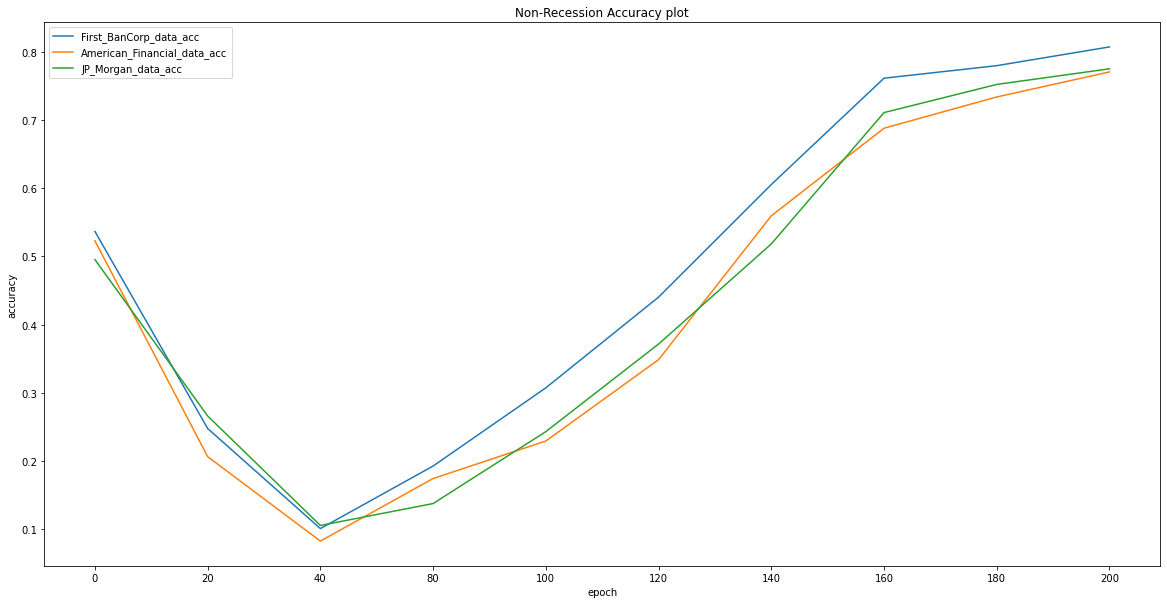

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

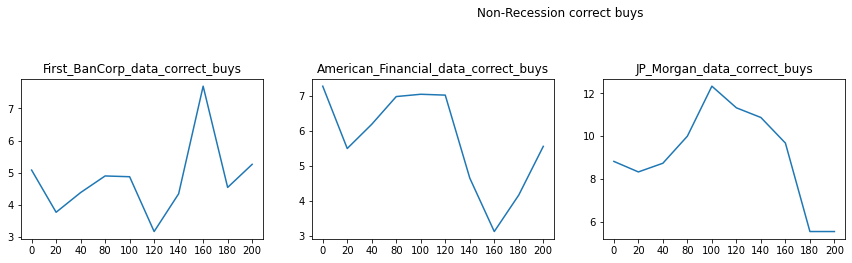

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

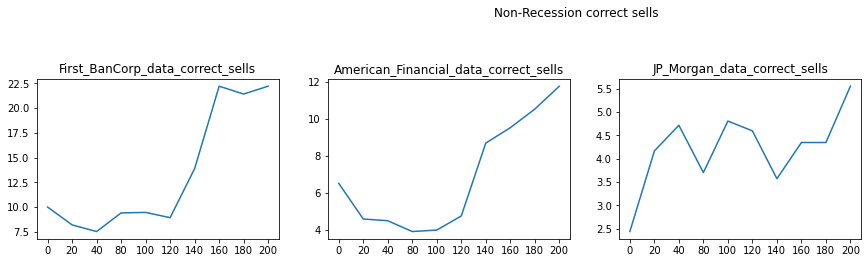

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

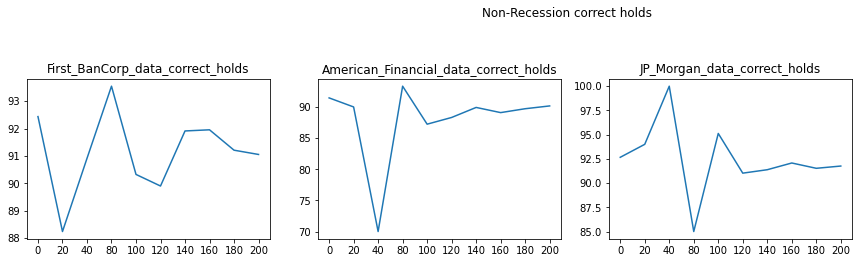

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

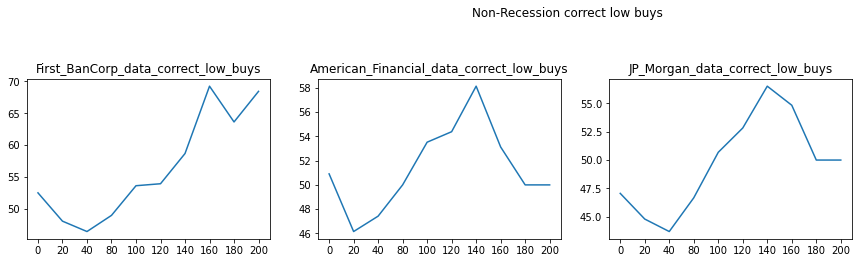

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

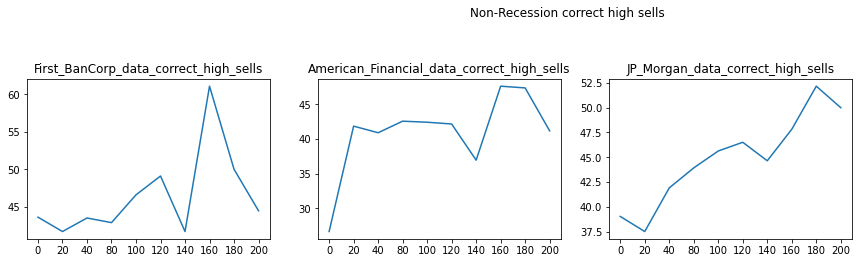

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

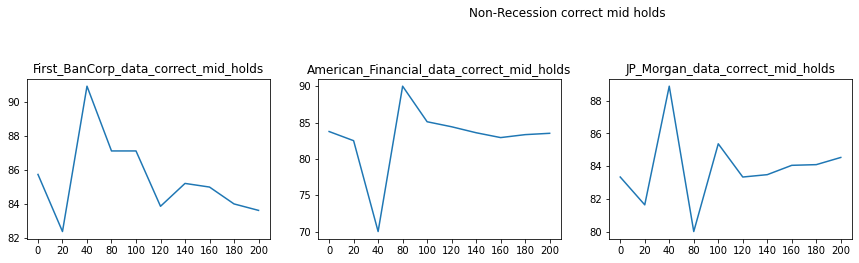

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

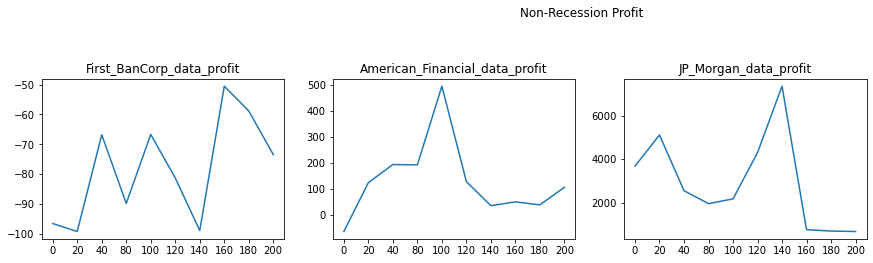

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [32]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


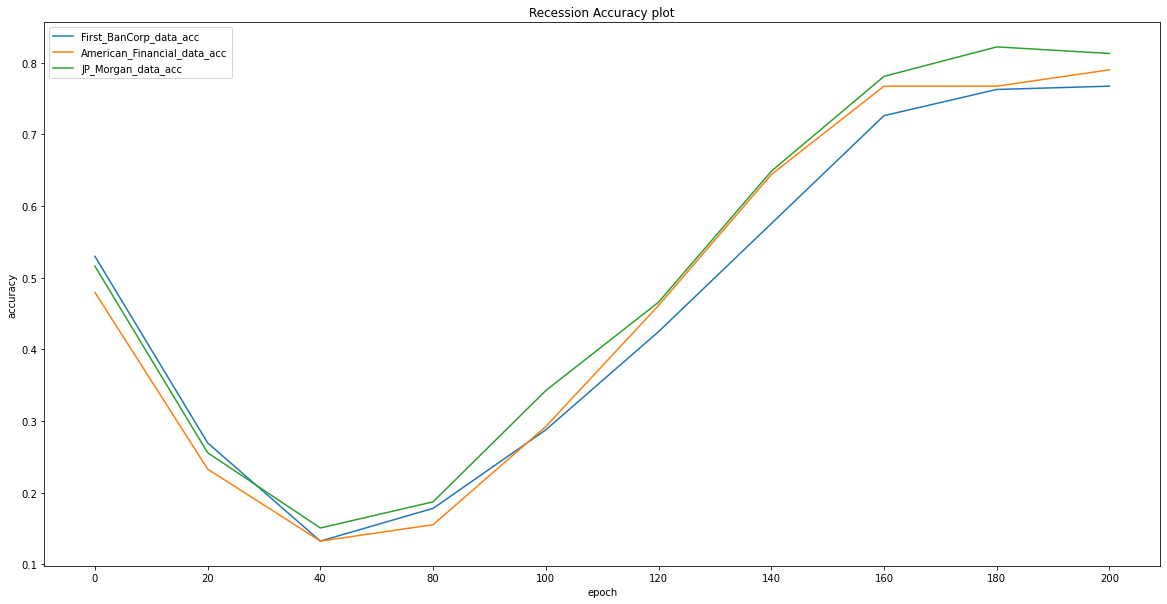

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

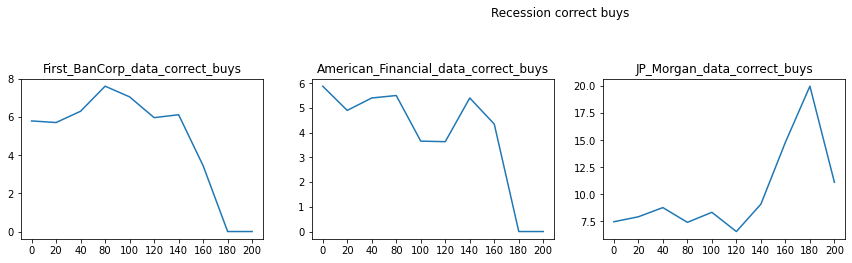

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

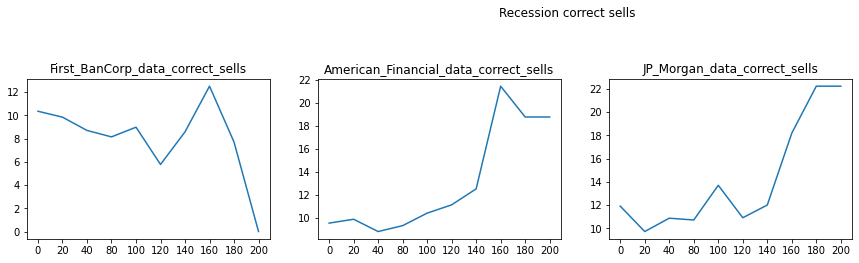

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

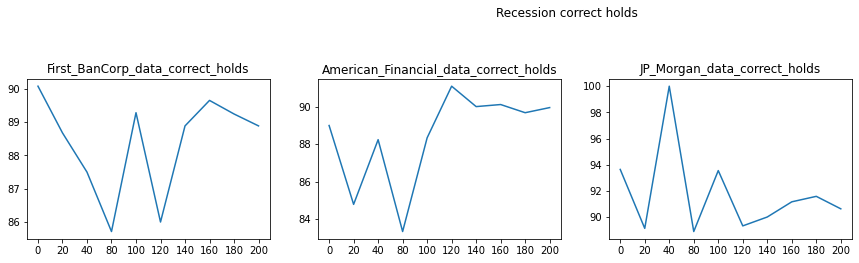

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

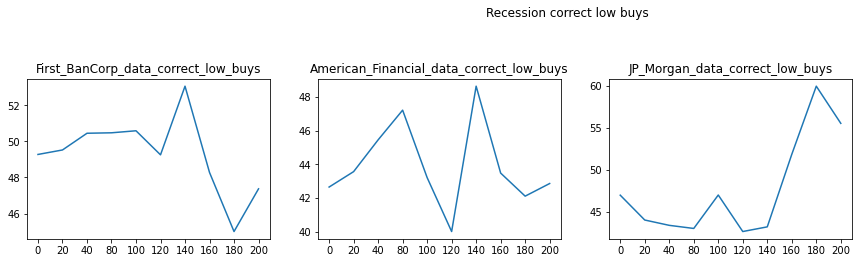

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

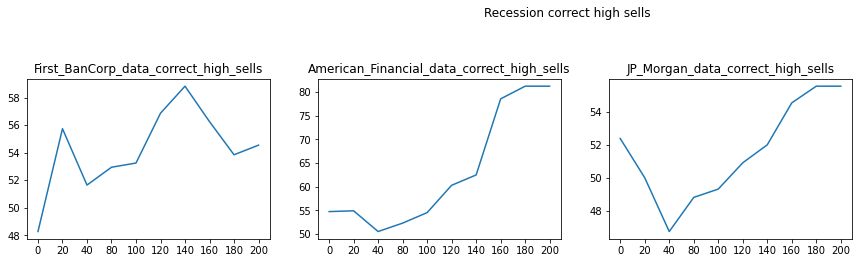

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

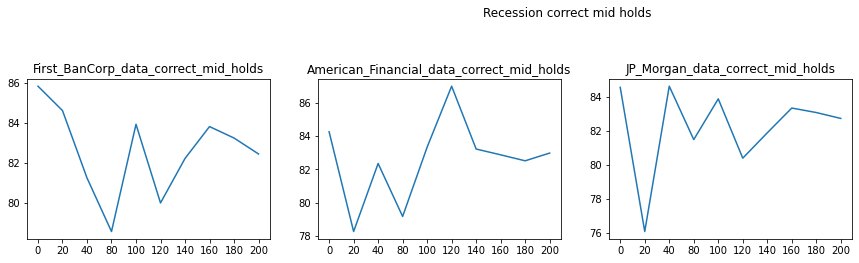

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

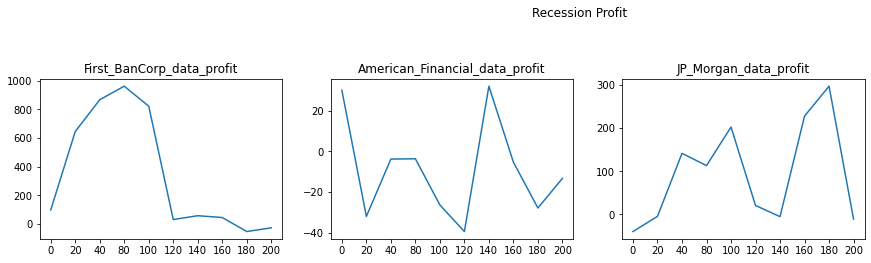

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

## Train American Financial Group, Inc Stock Data

In [41]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12    willr_14      OBV_7  labels
Date                                                             
2000-01-21    15.000000  16.189452 -100.000000  -550650.0     2.0
2000-01-24    15.166667  16.032100  -93.103439  -477300.0     2.0
2000-01-25    14.875000  15.854085  -92.187507  -762150.0     2.0
2000-01-26    14.708333  15.677815  -95.454544 -1036650.0     2.0
2000-01-27    14.666667  15.522254  -88.888864 -1157250.0     2.0


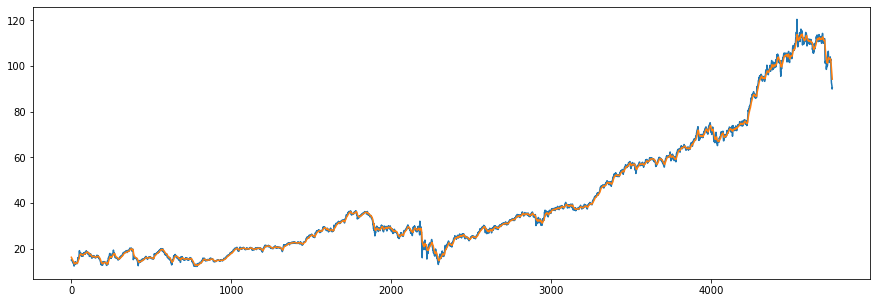

(4745, 64, 64, 1)

In [42]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/AFG_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [43]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [45]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [46]:
from collections import Counter

Counter(y)

Counter({2.0: 4310, 1.0: 217, 0.0: 218})

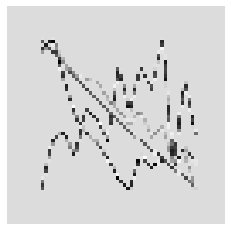

In [47]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [48]:
X = X/255

In [49]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [50]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [51]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AFGModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AFGModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.272030651340996, 2: 0.36697602474864655}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 47ms/step - loss: 0.2434 - accuracy: 0.3978 - mse: 1.5712 - weighted_accuracy: 0.3079 - weighted_mse: 1.6464 - val_loss: 0.2080 - val_accuracy: 0.0421 - val_mse: 0.8953 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.8953
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2053 - accuracy: 0.4539 - mse: 1.1624 - weighted_accuracy: 0.3321 - weighted_mse: 1.1833 - val_loss: 0.1926 - val_accuracy: 0.9083 - val_mse: 0.8112 - val_weighted_accuracy: 0.9083 - val_weighted_mse: 0.8112
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2063 - accuracy: 0.5400 - mse: 1.0844 - weighted_accuracy: 0.3000 - weighted_mse: 1.1318 - val_loss: 0.1878 - val_accuracy: 0.8988 - val_mse: 0.9038 - val_weighted_accuracy: 0.8988 - val_weighted_mse: 0.9038
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.0413 - mse: 0.9495 - weighted_accuracy: 0.0413 - weighted_mse: 0.9495
Test loss: 0.19518551230430603
Test accuracy: 0.04128440469503403


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 12
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 197
actual holds but predicted sell: 0
actual predicted holds: 0
Percentage buys correct: 4.128440366972477%
Percentage sells correct: 0%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 40.55299539170507%
Percentage high sells correct: 0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.14317747742488263
Shares owned at the moment: 696
Cash capital at the moment: $0.07443402049047165




Capital at the end of test period: $666.6403158511612
profit gaine

30/30 [==============================] - 0s 14ms/step - loss: 0.2020 - accuracy: 0.2600 - mse: 1.1659 - weighted_accuracy: 0.3228 - weighted_mse: 1.1505 - val_loss: 0.1915 - val_accuracy: 0.0453 - val_mse: 0.9951 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9951
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2024 - accuracy: 0.3001 - mse: 1.1532 - weighted_accuracy: 0.3302 - weighted_mse: 1.1455 - val_loss: 0.2033 - val_accuracy: 0.0506 - val_mse: 0.8969 - val_weighted_accuracy: 0.0506 - val_weighted_mse: 0.8969
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2000 - accuracy: 0.2742 - mse: 1.1324 - weighted_accuracy: 0.3662 - weighted_mse: 1.1427 - val_loss: 0.2012 - val_accuracy: 0.0558 - val_mse: 0.8965 - val_weighted_accuracy: 0.0558 - val_weighted_mse: 0.8965
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2002 - accuracy: 0.2777 - mse: 1.1341 - weighted_accuracy: 0.3275 - weighted_mse: 1.135

7/7 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.0731 - mse: 0.9796 - weighted_accuracy: 0.0731 - weighted_mse: 0.9796
Test loss: 0.19379480183124542
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 164
actual holds but predicted sell: 33
actual predicted holds: 0
Percentage buys correct: 6.593406593406593%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 48.06629834254144%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -69.97191811

7/7 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.0639 - mse: 0.9794 - weighted_accuracy: 0.0639 - weighted_mse: 0.9794
Test loss: 0.19438625872135162
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 152
actual holds but predicted sell: 45
actual predicted holds: 0
Percentage buys correct: 4.848484848484849%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 43.90243902439025%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9923833833479399
Shares owned at the moment: 100
Cash capital at the moment: $0.4887562347853276


Price increase from previously bough

7/7 [==============================] - 0s 3ms/step - loss: 0.1941 - accuracy: 0.0776 - mse: 0.9805 - weighted_accuracy: 0.0776 - weighted_mse: 0.9805
Test loss: 0.19405780732631683
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 153
actual holds but predicted sell: 44
actual predicted holds: 0
Percentage buys correct: 5.9523809523809526%
Percentage sells correct: 13.72549019607843%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.51497005988024%
Percentage high sells correct: 49.01960784313726%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9477687090784883


Price increase from previously bought:

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1954 - accuracy: 0.2756 - mse: 1.1592 - weighted_accuracy: 0.3849 - weighted_mse: 1.1520 - val_loss: 0.1956 - val_accuracy: 0.0695 - val_mse: 1.0034 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 1.0034
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1954 - accuracy: 0.2698 - mse: 1.1659 - weighted_accuracy: 0.4028 - weighted_mse: 1.1552 - val_loss: 0.1969 - val_accuracy: 0.0695 - val_mse: 1.0000 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 1.0000
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1938 - accuracy: 0.2629 - mse: 1.1706 - weighted_accuracy: 0.4130 - weighted_mse: 1.1655 - val_loss: 0.1929 - val_accuracy: 0.0590 - val_mse: 1.0218 - val_weighted_accuracy: 0.0590 - val_weighted_mse: 1.0218
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1923 - accuracy: 0.2566 - mse: 1.1975 - weighted_accuracy: 0.4198 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1932 - accuracy: 0.0868 - mse: 1.1235 - weighted_accuracy: 0.0868 - weighted_mse: 1.1235
Test loss: 0.19322597980499268
Test accuracy: 0.08675798773765564


number of predictions: 219
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 136
actual holds but predicted sell: 61
actual predicted holds: 0
Percentage buys correct: 7.947019867549669%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 52.0%
Percentage high sells correct: 57.35294117647059%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -29.490952258450363%
Sha

7/7 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.0550 - mse: 1.1301 - weighted_accuracy: 0.0550 - weighted_mse: 1.1301
Test loss: 0.1953980177640915
Test accuracy: 0.055045872926712036


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 7
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 113
actual holds but predicted sell: 84
actual predicted holds: 0
Percentage buys correct: 5.511811023622047%
Percentage sells correct: 5.4945054945054945%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.09448818897638%
Percentage high sells correct: 43.333333333333336%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.22261675266817016
Shares owned at the moment: 447
Cash capital at the moment: $0.21665991411059338


Price increase from previously bou

7/7 [==============================] - 0s 3ms/step - loss: 0.1935 - accuracy: 0.0685 - mse: 1.1237 - weighted_accuracy: 0.0685 - weighted_mse: 1.1237
Test loss: 0.1934611052274704
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 131
actual holds but predicted sell: 66
actual predicted holds: 0
Percentage buys correct: 6.206896551724138%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9845373613600361
Shares owned at the moment: 101
Cash capital at the moment: $0.2882712505185907


Price increase from previously bought: -62.9538165

7/7 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.0868 - mse: 1.1168 - weighted_accuracy: 0.0868 - weighted_mse: 1.1168
Test loss: 0.1922968477010727
Test accuracy: 0.08675798773765564


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 133
actual holds but predicted sell: 64
actual predicted holds: 0
Percentage buys correct: 6.8493150684931505%
Percentage sells correct: 12.32876712328767%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.758620689655174%
Percentage high sells correct: 46.57534246575342%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9477687090784883


Price increase from previously bough

Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1874 - accuracy: 0.1491 - mse: 1.1810 - weighted_accuracy: 0.4331 - weighted_mse: 1.1653 - val_loss: 0.1947 - val_accuracy: 0.0674 - val_mse: 1.1137 - val_weighted_accuracy: 0.0674 - val_weighted_mse: 1.1137
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1841 - accuracy: 0.1565 - mse: 1.2082 - weighted_accuracy: 0.4740 - weighted_mse: 1.1825 - val_loss: 0.1957 - val_accuracy: 0.0727 - val_mse: 1.1091 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.1091
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1839 - accuracy: 0.1507 - mse: 1.1800 - weighted_accuracy: 0.4955 - weighted_mse: 1.1548 - val_loss: 0.1951 - val_accuracy: 0.0664 - val_mse: 1.1137 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 1.1137
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1840 - accuracy: 0.1325 - mse: 1.2372 - weighted_accuracy: 0.4797 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.0822 - mse: 1.2581 - weighted_accuracy: 0.0822 - weighted_mse: 1.2581
Test loss: 0.19465358555316925
Test accuracy: 0.08219178020954132


number of predictions: 219
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 140
actual holds but predicted sell: 57
actual predicted holds: 0
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 60.317460317460316%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -29.490952

7/7 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.0642 - mse: 1.2618 - weighted_accuracy: 0.0642 - weighted_mse: 1.2618
Test loss: 0.19733518362045288
Test accuracy: 0.06422018259763718


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 119
actual holds but predicted sell: 78
actual predicted holds: 0
Percentage buys correct: 6.015037593984962%
Percentage sells correct: 7.0588235294117645%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 40.476190476190474%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.22261675266817016
Shares owned at the moment: 447
Cash capital at the moment: $0.21665991411059338


Price increase from previously bou

1         566.640316  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1951 - accuracy: 0.0731 - mse: 1.2479 - weighted_accuracy: 0.0731 - weighted_mse: 1.2479
Test loss: 0.1950657218694687
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 136
actual holds but predicted sell: 61
actual predicted holds: 0
Percentage buys correct: 7.189542483660131%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 45.39473684210526%
Percentage high sells correct: 51.515151515151516%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase

7/7 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.0596 - mse: 1.2495 - weighted_accuracy: 0.0596 - weighted_mse: 1.2495
Test loss: 0.19465938210487366
Test accuracy: 0.059633027762174606


number of predictions: 218
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 113
actual holds but predicted sell: 88
actual predicted holds: 0
Percentage buys correct: 8.59375%
Percentage sells correct: 2.2222222222222223%
Percentage holds correct: 0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 41.40625%
Percentage high sells correct: 41.57303370786517%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previously bought: 198.53918945

7/7 [==============================] - 0s 4ms/step - loss: 0.1930 - accuracy: 0.0822 - mse: 1.2353 - weighted_accuracy: 0.0822 - weighted_mse: 1.2353
Test loss: 0.1930290162563324
Test accuracy: 0.08219178020954132


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 144
actual holds but predicted sell: 53
actual predicted holds: 0
Percentage buys correct: 6.329113924050633%
Percentage sells correct: 13.114754098360656%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.67088607594937%
Percentage high sells correct: 48.333333333333336%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999854


Price increase from previously bough




RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1691 - accuracy: 0.1225 - mse: 1.3100 - weighted_accuracy: 0.5397 - weighted_mse: 1.2750 - val_loss: 0.1953 - val_accuracy: 0.0674 - val_mse: 1.2047 - val_weighted_accuracy: 0.0674 - val_weighted_mse: 1.2047
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1658 - accuracy: 0.1254 - mse: 1.3286 - weighted_accuracy: 0.5372 - weighted_mse: 1.3077 - val_loss: 0.1976 - val_accuracy: 0.0727 - val_mse: 1.2791 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.2791
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1642 - accuracy: 0.1249 - mse: 1.3367 - weighted_accuracy: 0.5461 - weighted_mse: 1.2919 - val_loss: 0.1954 - val_accuracy: 0.0717 - val_mse: 1.2167 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.2167
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1658 - accuracy: 0.1151 - mse: 1.3303 - weight

7/7 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.1735 - mse: 1.3473 - weighted_accuracy: 0.1735 - weighted_mse: 1.3473
Test loss: 0.19371002912521362
Test accuracy: 0.17351597547531128


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 122
actual holds but predicted sell: 54
actual predicted holds: 21
Percentage buys correct: 8.148148148148149%
Percentage sells correct: 10.0%
Percentage holds correct: 87.5%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 79.16666666666667%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -4.322351640976596%
Share price

7/7 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.1881 - mse: 1.3482 - weighted_accuracy: 0.1881 - weighted_mse: 1.3482
Test loss: 0.1965395212173462
Test accuracy: 0.18807339668273926


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 5
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 97
actual holds but predicted sell: 71
actual predicted holds: 29
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.625%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 44.15584415584416%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.22261675266817016
Shares owned at the moment: 447
Cash capital at the moment: $0.21665991411059338


Price increase from previ

7/7 [==============================] - 0s 2ms/step - loss: 0.1938 - accuracy: 0.1461 - mse: 1.3270 - weighted_accuracy: 0.1461 - weighted_mse: 1.3270
Test loss: 0.1937818080186844
Test accuracy: 0.14611871540546417


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 124
actual holds but predicted sell: 54
actual predicted holds: 19
Percentage buys correct: 7.299270072992701%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 76.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 50.87719298245614%
Percentage mid holds correct: 72.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -2.01

7/7 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.1697 - mse: 1.3384 - weighted_accuracy: 0.1697 - weighted_mse: 1.3384
Test loss: 0.19213756918907166
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 96
actual holds but predicted sell: 82
actual predicted holds: 23
Percentage buys correct: 10.185185185185185%
Percentage sells correct: 3.5294117647058822%
Percentage holds correct: 92.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previ

7/7 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.2055 - mse: 1.3203 - weighted_accuracy: 0.2055 - weighted_mse: 1.3203
Test loss: 0.19149336218833923
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 125
actual holds but predicted sell: 43
actual predicted holds: 29
Percentage buys correct: 6.569343065693431%
Percentage sells correct: 14.0%
Percentage holds correct: 90.625%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.7956204379562%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999854


Price increase from previously bought: -90

30/30 [==============================] - 0s 15ms/step - loss: 0.1555 - accuracy: 0.2121 - mse: 1.4286 - weighted_accuracy: 0.5580 - weighted_mse: 1.4093 - val_loss: 0.1967 - val_accuracy: 0.1675 - val_mse: 1.3569 - val_weighted_accuracy: 0.1675 - val_weighted_mse: 1.3569
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1497 - accuracy: 0.2276 - mse: 1.4453 - weighted_accuracy: 0.6092 - weighted_mse: 1.4463 - val_loss: 0.1952 - val_accuracy: 0.1834 - val_mse: 1.3705 - val_weighted_accuracy: 0.1834 - val_weighted_mse: 1.3705
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1501 - accuracy: 0.2168 - mse: 1.4673 - weighted_accuracy: 0.5689 - weighted_mse: 1.4778 - val_loss: 0.1926 - val_accuracy: 0.1844 - val_mse: 1.3063 - val_weighted_accuracy: 0.1844 - val_weighted_mse: 1.3063
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1523 - accuracy: 0.2231 - mse: 1.4625 - weighted_accuracy: 0.5949 - weighted_mse: 1.442

7/7 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.2694 - mse: 1.3878 - weighted_accuracy: 0.2694 - weighted_mse: 1.3878
Test loss: 0.18735957145690918
Test accuracy: 0.26940637826919556


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 96
actual holds but predicted sell: 56
actual predicted holds: 45
Percentage buys correct: 6.730769230769231%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 86.53846153846153%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 51.45631067961165%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 78.84615384615384%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from 

7/7 [==============================] - 0s 2ms/step - loss: 0.1892 - accuracy: 0.2569 - mse: 1.3915 - weighted_accuracy: 0.2569 - weighted_mse: 1.3915
Test loss: 0.18920138478279114
Test accuracy: 0.2568807303905487


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 86
actual holds but predicted sell: 66
actual predicted holds: 45
Percentage buys correct: 5.319148936170213%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 88.23529411764706%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.61702127659574%
Percentage high sells correct: 43.05555555555556%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.22261675266817016
Shares owned at the moment: 447
Cash capital at the moment: $0.21665991411059338


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.3014 - mse: 1.3654 - weighted_accuracy: 0.3014 - weighted_mse: 1.3654
Test loss: 0.18735048174858093
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 93
actual holds but predicted sell: 50
actual predicted holds: 54
Percentage buys correct: 6.930693069306931%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 85.71428571428571%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.09090909090909%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

7/7 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.2706 - mse: 1.3799 - weighted_accuracy: 0.2706 - weighted_mse: 1.3799
Test loss: 0.1851862221956253
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 81
actual predicted holds: 44
Percentage buys correct: 12.5%
Percentage sells correct: 4.705882352941177%
Percentage holds correct: 97.77777777777777%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 48.86363636363637%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 91.11111111111111%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase f

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1429 - accuracy: 0.3240 - mse: 1.5731 - weighted_accuracy: 0.6046 - weighted_mse: 1.6555 - val_loss: 0.1893 - val_accuracy: 0.2929 - val_mse: 1.4461 - val_weighted_accuracy: 0.2929 - val_weighted_mse: 1.4461
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1420 - accuracy: 0.3201 - mse: 1.6164 - weighted_accuracy: 0.5977 - weighted_mse: 1.6883 - val_loss: 0.1880 - val_accuracy: 0.3214 - val_mse: 1.4751 - val_weighted_accuracy: 0.3214 - val_weighted_mse: 1.4751
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1389 - accuracy: 0.3238 - mse: 1.6566 - weighted_accuracy: 0.6190 - weighted_mse: 1.7521 - val_loss: 0.1867 - val_accuracy: 0.3562 - val_mse: 1.5049 - val_weighted_accuracy: 0.3562 - val_weighted_mse: 1.5049
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1424 - accuracy: 0.3356 - mse: 1.6313 - weighted_accuracy: 0.6088 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1795 - accuracy: 0.3516 - mse: 1.4996 - weighted_accuracy: 0.3516 - weighted_mse: 1.4996
Test loss: 0.17951513826847076
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 91
actual holds but predicted sell: 40
actual predicted holds: 66
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 88.0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 52.04081632653061%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 77.33333333333333%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -4.322

7/7 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.3699 - mse: 1.4761 - weighted_accuracy: 0.3699 - weighted_mse: 1.4761
Test loss: 0.17975175380706787
Test accuracy: 0.36986300349235535


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 91
actual holds but predicted sell: 32
actual predicted holds: 74
Percentage buys correct: 5.1020408163265305%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 85.05747126436782%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.51546391752577%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 79.3103448275862%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1774 - accuracy: 0.3973 - mse: 1.4814 - weighted_accuracy: 0.3973 - weighted_mse: 1.4814
Test loss: 0.17737102508544922
Test accuracy: 0.39726027846336365


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 90
actual holds but predicted sell: 33
actual predicted holds: 74
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 13.157894736842104%
Percentage holds correct: 92.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.554455445544555%
Percentage high sells correct: 54.054054054054056%
Percentage mid holds correct: 88.75%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999

Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1348 - accuracy: 0.4075 - mse: 1.7635 - weighted_accuracy: 0.6225 - weighted_mse: 2.0042 - val_loss: 0.1773 - val_accuracy: 0.4331 - val_mse: 1.5655 - val_weighted_accuracy: 0.4331 - val_weighted_mse: 1.5655
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1356 - accuracy: 0.4307 - mse: 1.7529 - weighted_accuracy: 0.6219 - weighted_mse: 1.9990 - val_loss: 0.1758 - val_accuracy: 0.4415 - val_mse: 1.5681 - val_weighted_accuracy: 0.4415 - val_weighted_mse: 1.5681
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1347 - accuracy: 0.4262 - mse: 1.7904 - weighted_accuracy: 0.6239 - weighted_mse: 2.0683 - val_loss: 0.1735 - val_accuracy: 0.4731 - val_mse: 1.6122 - val_weighted_accuracy: 0.4731 - val_weighted_mse: 1.6122
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1327 - accuracy: 0.4452 - mse: 1.7758 - weighted_accuracy: 0.6454 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1700 - accuracy: 0.4521 - mse: 1.6590 - weighted_accuracy: 0.4521 - weighted_mse: 1.6590
Test loss: 0.170014888048172
Test accuracy: 0.45205479860305786


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 67
actual holds but predicted sell: 39
actual predicted holds: 91
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 87.5%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 51.388888888888886%
Percentage high sells correct: 55.81395348837209%
Percentage mid holds correct: 77.66990291262135%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously boug

7/7 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.4749 - mse: 1.6273 - weighted_accuracy: 0.4749 - weighted_mse: 1.6273
Test loss: 0.17032352089881897
Test accuracy: 0.47488585114479065


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 67
actual holds but predicted sell: 33
actual predicted holds: 97
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 87.38738738738739%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.11267605633803%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 82.88288288288288%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from 

Shares owned at the moment: 0
Cash capital at the moment: $234.96231853739098


Share price: $0.4711465475768166
Shares owned at the moment: 497
Cash capital at the moment: $0.15854484781252154


Price increase from previously bought: 14.0165976872918%
Share price: $0.5386625231433115
Shares owned at the moment: 0
Cash capital at the moment: $267.1376018465322


Share price: $0.7628662717522834
Shares owned at the moment: 349
Cash capital at the moment: $0.16511210067108095


Price increase from previously bought: 10.650039148969404%
Share price: $0.8464331358761423
Shares owned at the moment: 0
Cash capital at the moment: $294.7579123192876


Share price: $0.7959873750504178
Shares owned at the moment: 369
Cash capital at the moment: $0.23084273685100243


Price increase from previously bought: 13.770492343539932%
Share price: $0.9080891521651451
Shares owned at the moment: 0
Cash capital at the moment: $334.39425641862994




Capital at the end of test period: $334.39425641862994
pro

30/30 [==============================] - 0s 13ms/step - loss: 0.1296 - accuracy: 0.4966 - mse: 1.9059 - weighted_accuracy: 0.6643 - weighted_mse: 2.2812 - val_loss: 0.1692 - val_accuracy: 0.4921 - val_mse: 1.6241 - val_weighted_accuracy: 0.4921 - val_weighted_mse: 1.6241
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1262 - accuracy: 0.4947 - mse: 1.9588 - weighted_accuracy: 0.6618 - weighted_mse: 2.4134 - val_loss: 0.1654 - val_accuracy: 0.5627 - val_mse: 1.7010 - val_weighted_accuracy: 0.5627 - val_weighted_mse: 1.7010
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1295 - accuracy: 0.5063 - mse: 1.9035 - weighted_accuracy: 0.6533 - weighted_mse: 2.3109 - val_loss: 0.1649 - val_accuracy: 0.5553 - val_mse: 1.6904 - val_weighted_accuracy: 0.5553 - val_weighted_mse: 1.6904
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1272 - accuracy: 0.4918 - mse: 1.9215 - weighted_accuracy: 0.6589 - weighted_mse: 2.345

7/7 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.5297 - mse: 1.7522 - weighted_accuracy: 0.5297 - weighted_mse: 1.7522
Test loss: 0.157981276512146
Test accuracy: 0.5296803712844849


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 62
actual holds but predicted sell: 25
actual predicted holds: 110
Percentage buys correct: 5.970149253731344%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 88.0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 79.2%


Capital: 100
Share price: $0.9832619307246573
Shares owned at the moment: 101
Cash capital at the moment: $0.41744399555084044


Price increase from previously bought: -70.60

7/7 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.5890 - mse: 1.7279 - weighted_accuracy: 0.5890 - weighted_mse: 1.7279
Test loss: 0.15901021659374237
Test accuracy: 0.5890411138534546


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 62
actual holds but predicted sell: 11
actual predicted holds: 124
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 89.20863309352518%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.73134328358209%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 84.89208633093526%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.6027 - mse: 1.7349 - weighted_accuracy: 0.6027 - weighted_mse: 1.7349
Test loss: 0.15444315969944
Test accuracy: 0.6027397513389587


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 57
actual holds but predicted sell: 15
actual predicted holds: 125
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 89.92805755395683%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.38709677419355%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 84.05797101449275%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price inc

30/30 [==============================] - 0s 10ms/step - loss: 0.1172 - accuracy: 0.6004 - mse: 2.2211 - weighted_accuracy: 0.7078 - weighted_mse: 3.0813 - val_loss: 0.1415 - val_accuracy: 0.7281 - val_mse: 1.9018 - val_weighted_accuracy: 0.7281 - val_weighted_mse: 1.9018
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1141 - accuracy: 0.5814 - mse: 2.2447 - weighted_accuracy: 0.7100 - weighted_mse: 3.1308 - val_loss: 0.1426 - val_accuracy: 0.7187 - val_mse: 1.8952 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 1.8952
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1176 - accuracy: 0.6077 - mse: 2.2402 - weighted_accuracy: 0.7051 - weighted_mse: 3.0595 - val_loss: 0.1398 - val_accuracy: 0.7460 - val_mse: 1.9469 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 1.9469
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1121 - accuracy: 0.6062 - mse: 2.3200 - weighted_accuracy: 0.7300 - weighted_mse: 3.

7/7 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.7156 - mse: 2.0232 - weighted_accuracy: 0.7156 - weighted_mse: 2.0232
Test loss: 0.14163272082805634
Test accuracy: 0.7155963182449341


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 31
actual holds but predicted sell: 15
actual predicted holds: 151
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 90.96385542168674%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 35.294117647058826%
Percentage mid holds correct: 83.03030303030303%


Capital: 100
Share price: $0.17705608361672387
Shares owned at the moment: 563
Cash capital at the moment: $0.043297842324861335


P

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.7169 - mse: 2.0110 - weighted_accuracy: 0.7169 - weighted_mse: 2.0110
Test loss: 0.13805532455444336
Test accuracy: 0.7168949842453003


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 31
actual holds but predicted sell: 13
actual predicted holds: 153
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 83.4319526627219%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price i

In [54]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


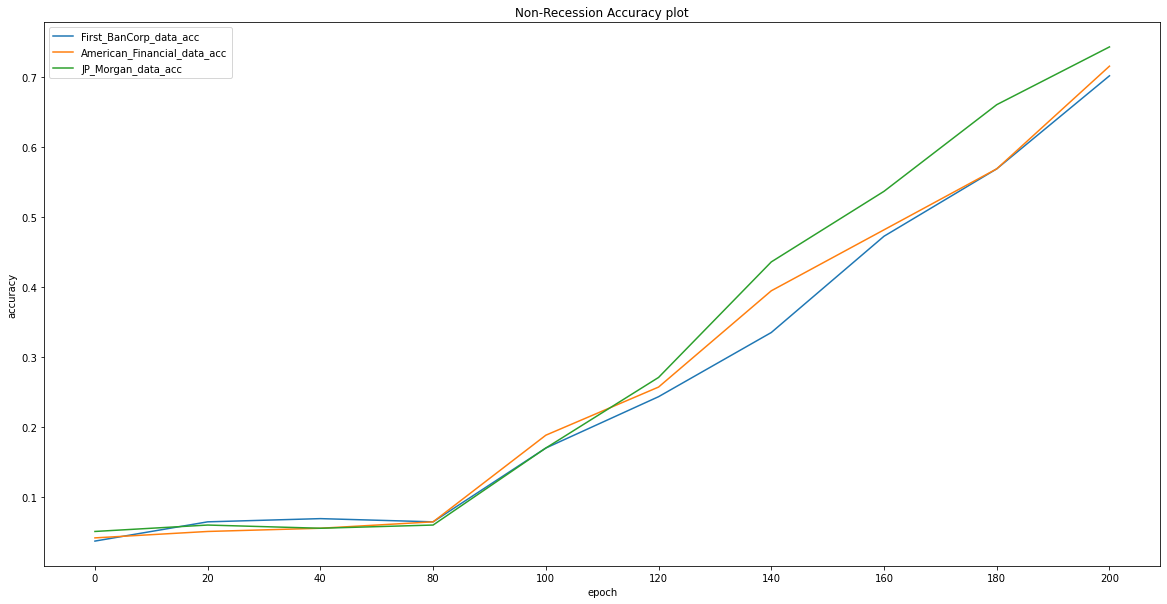

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

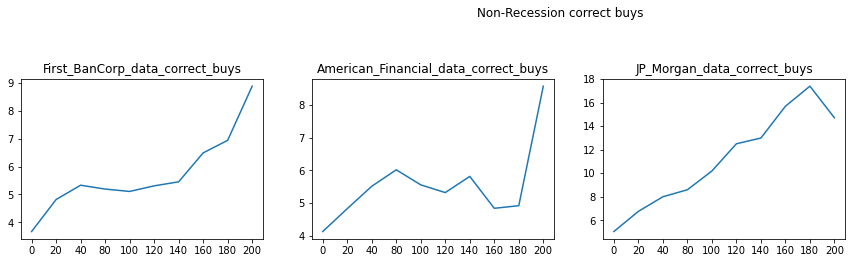

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

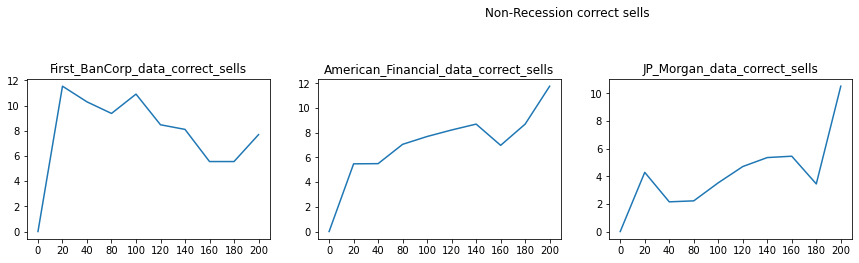

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

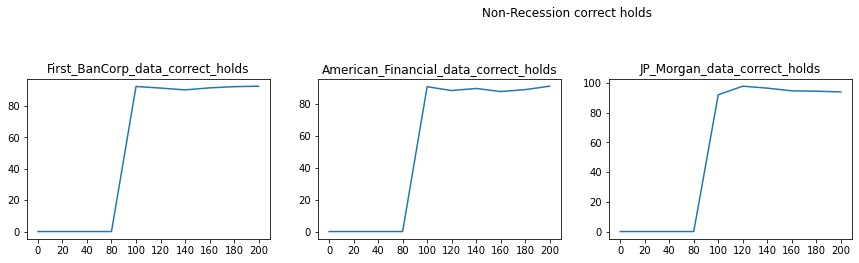

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

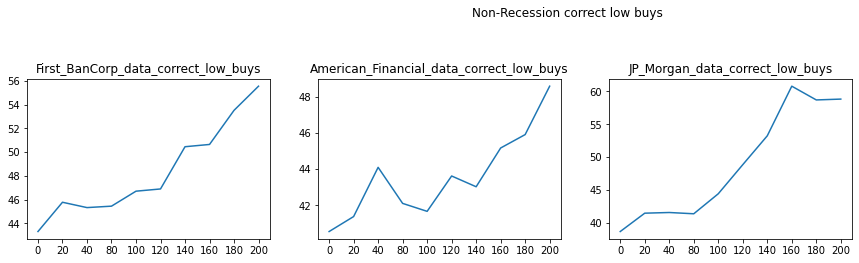

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

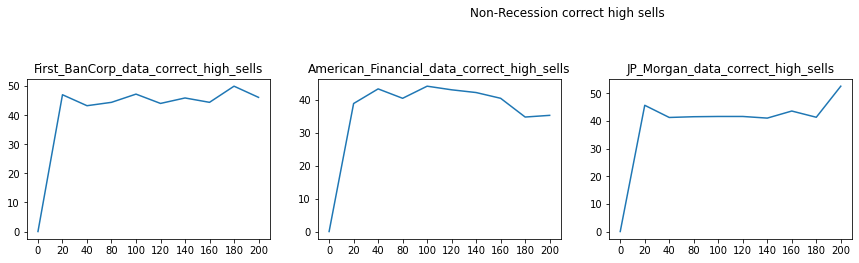

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

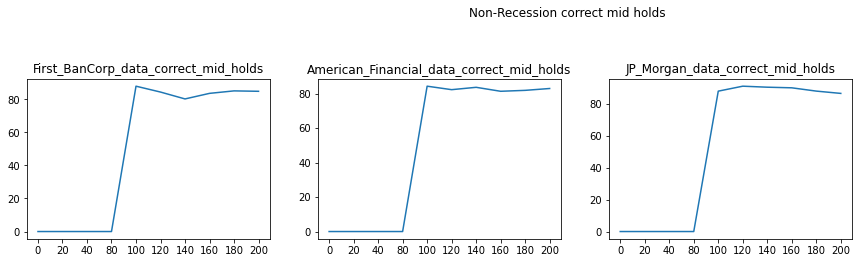

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

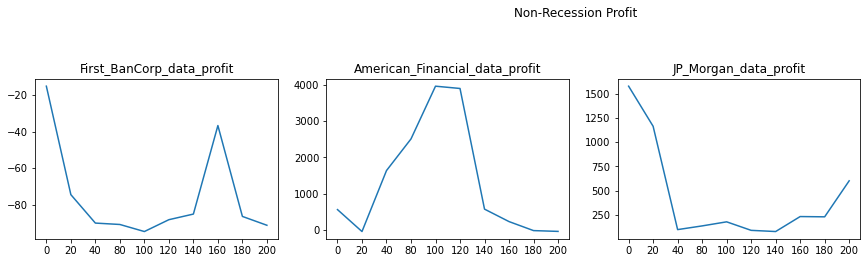

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [63]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


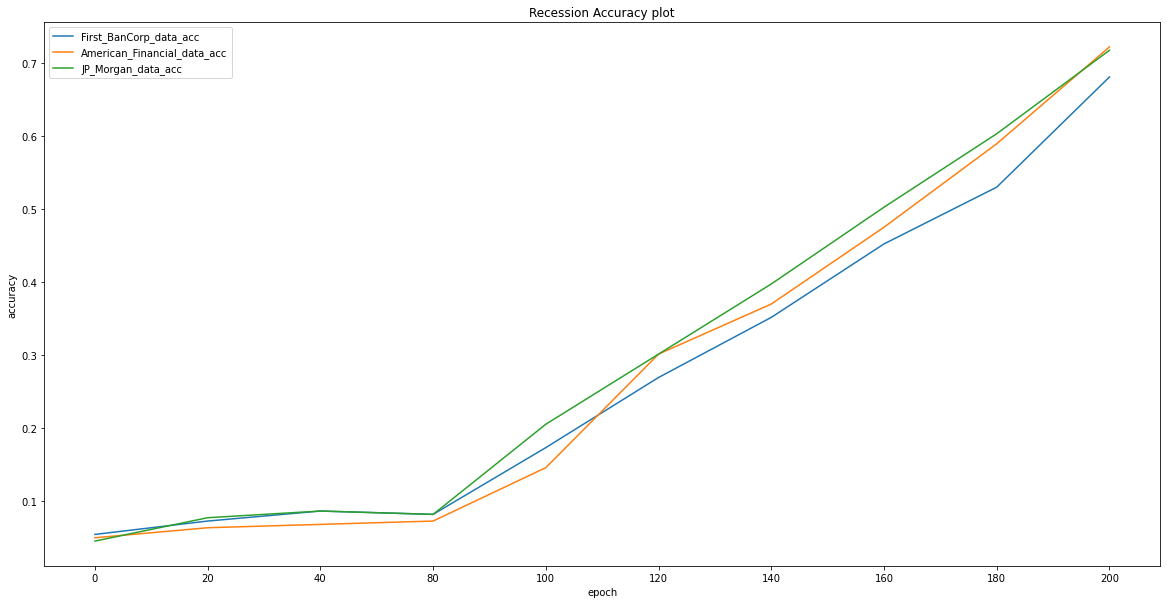

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

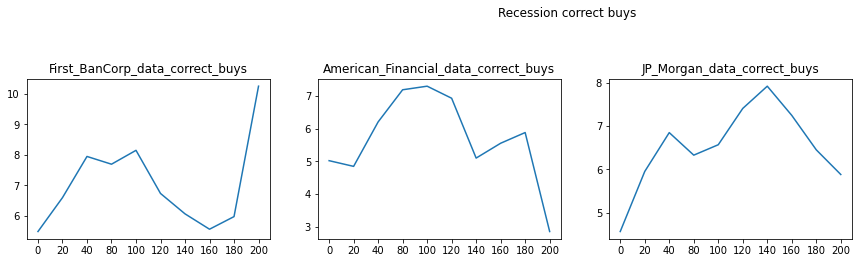

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

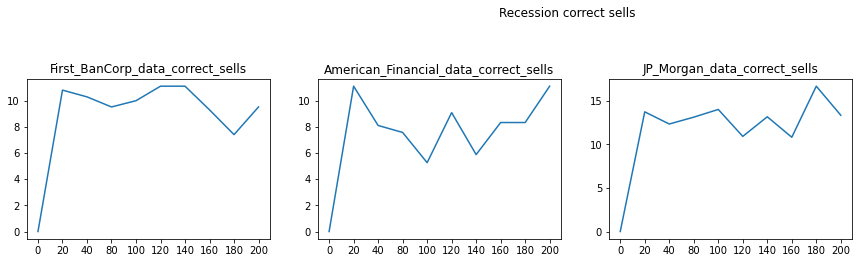

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

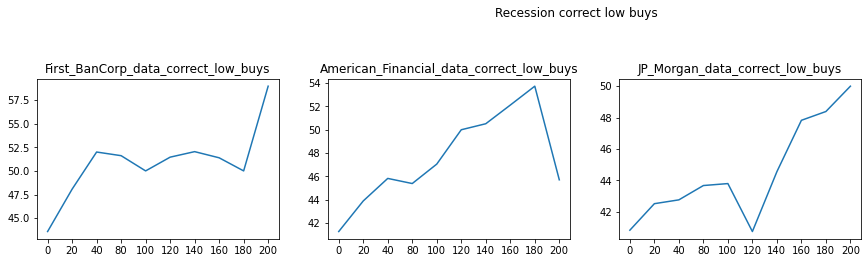

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

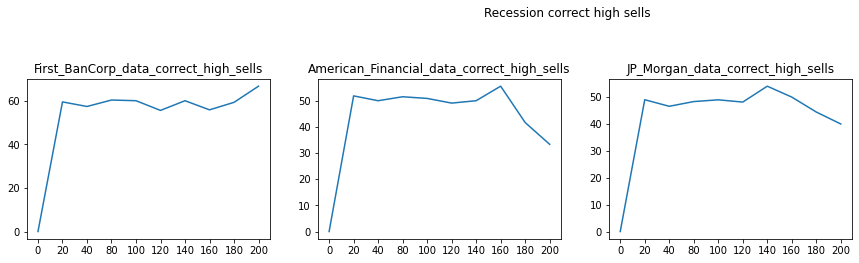

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

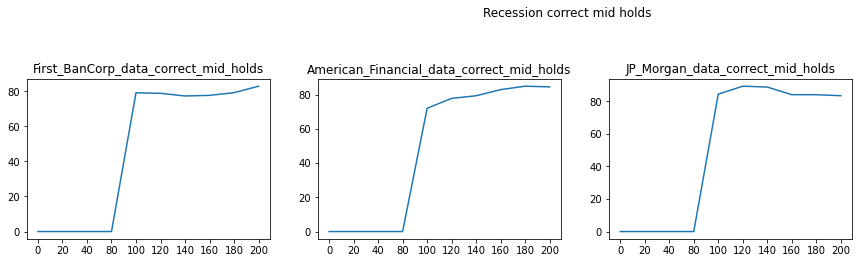

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

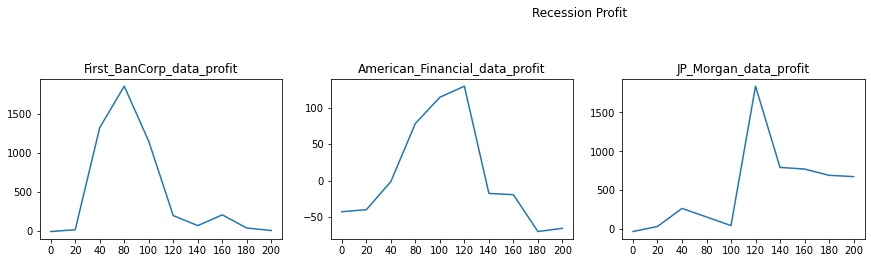

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

## Train JP Morgan Stock Data

In [71]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


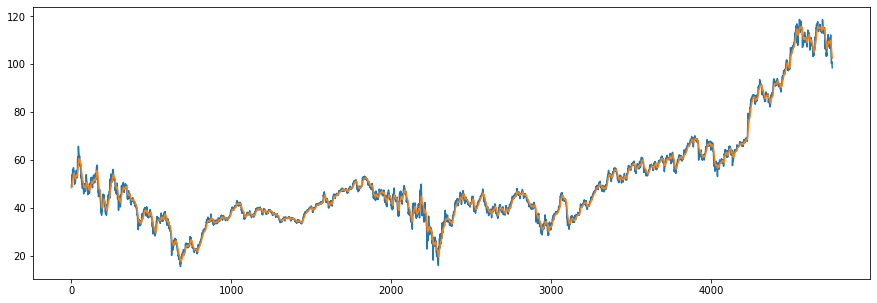

(4745, 64, 64, 1)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [76]:
from collections import Counter

Counter(y)

Counter({2.0: 4326, 1.0: 214, 0.0: 205})

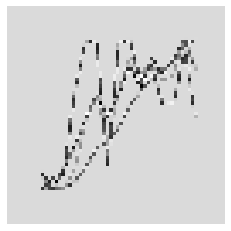

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JPMModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JPMModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2458 - accuracy: 0.3501 - mse: 1.6253 - weighted_accuracy: 0.3201 - weighted_mse: 1.7327 - val_loss: 0.1991 - val_accuracy: 0.0927 - val_mse: 1.0087 - val_weighted_accuracy: 0.0927 - val_weighted_mse: 1.0087
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2039 - accuracy: 0.3512 - mse: 1.1816 - weighted_accuracy: 0.3423 - weighted_mse: 1.1780 - val_loss: 0.2072 - val_accuracy: 0.0432 - val_mse: 0.9964 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.9964
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2029 - accuracy: 0.3217 - mse: 1.1828 - weighted_accuracy: 0.3294 - weighted_mse: 1.1860 - val_loss: 0.1995 - val_accuracy: 0.5121 - val_mse: 0.8274 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 0.8274
Epoch 4/20
30/30 [==============================] - 0

7/7 [==============================] - 0s 2ms/step - loss: 0.2001 - accuracy: 0.0639 - mse: 0.8949 - weighted_accuracy: 0.0639 - weighted_mse: 0.8949
Test loss: 0.20008651912212372
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 124
actual holds but predicted sell: 71
actual predicted holds: 2
Percentage buys correct: 5.797101449275362%
Percentage sells correct: 5.063291139240507%
Percentage holds correct: 100.0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 44.52554744525548%
Percentage high sells correct: 45.56962025316456%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -5.73

7/7 [==============================] - 0s 2ms/step - loss: 0.2006 - accuracy: 0.0594 - mse: 0.8959 - weighted_accuracy: 0.0594 - weighted_mse: 0.8959
Test loss: 0.20059190690517426
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 120
actual holds but predicted sell: 76
actual predicted holds: 1
Percentage buys correct: 4.580152671755725%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 43.07692307692308%
Percentage high sells correct: 45.97701149425287%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9769874796043578
Shares owned at the moment: 102
Cash capital at the moment: $0.07323209232647798


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.0685 - mse: 0.8975 - weighted_accuracy: 0.0685 - weighted_mse: 0.8975
Test loss: 0.20023971796035767
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 88
actual predicted holds: 0
Percentage buys correct: 7.258064516129032%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 41.46341463414634%
Percentage high sells correct: 48.421052631578945%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously bought:

30/30 [==============================] - 0s 9ms/step - loss: 0.1965 - accuracy: 0.2295 - mse: 1.1746 - weighted_accuracy: 0.4112 - weighted_mse: 1.1575 - val_loss: 0.1981 - val_accuracy: 0.0727 - val_mse: 1.0551 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.0551
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1935 - accuracy: 0.2885 - mse: 1.2043 - weighted_accuracy: 0.4451 - weighted_mse: 1.2113 - val_loss: 0.1940 - val_accuracy: 0.2150 - val_mse: 0.9841 - val_weighted_accuracy: 0.2150 - val_weighted_mse: 0.9841
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1949 - accuracy: 0.3456 - mse: 1.1934 - weighted_accuracy: 0.4065 - weighted_mse: 1.1960 - val_loss: 0.1950 - val_accuracy: 0.1401 - val_mse: 1.0219 - val_weighted_accuracy: 0.1401 - val_weighted_mse: 1.0219
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1936 - accuracy: 0.2903 - mse: 1.1737 - weighted_accuracy: 0.4255 - weighted_mse: 1.1688 

7/7 [==============================] - 0s 2ms/step - loss: 0.1938 - accuracy: 0.1781 - mse: 1.0592 - weighted_accuracy: 0.1781 - weighted_mse: 1.0592
Test loss: 0.19383347034454346
Test accuracy: 0.1780821979045868


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 66
actual holds but predicted sell: 104
actual predicted holds: 27
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 87.09677419354838%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.70422535211268%
Percentage high sells correct: 47.41379310344828%
Percentage mid holds correct: 77.41935483870968%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from 

7/7 [==============================] - 0s 2ms/step - loss: 0.1942 - accuracy: 0.1826 - mse: 1.0771 - weighted_accuracy: 0.1826 - weighted_mse: 1.0771
Test loss: 0.19424118101596832
Test accuracy: 0.1826484054327011


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 6
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 56
actual holds but predicted sell: 115
actual predicted holds: 26
Percentage buys correct: 6.557377049180328%
Percentage sells correct: 7.633587786259542%
Percentage holds correct: 96.29629629629629%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 47.32824427480916%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.8896447469246227
Shares owned at the moment: 112
Cash capital at the moment: $0.0857777623894691


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.1553 - mse: 1.0733 - weighted_accuracy: 0.1553 - weighted_mse: 1.0733
Test loss: 0.19360052049160004
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 1
actual holds but predicted buy: 64
actual holds but predicted sell: 117
actual predicted holds: 16
Percentage buys correct: 9.859154929577464%
Percentage sells correct: 8.396946564885496%
Percentage holds correct: 94.11764705882354%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.142857142857146%
Percentage high sells correct: 47.32824427480916%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price 

Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.2255 - mse: 1.2682 - weighted_accuracy: 0.5044 - weighted_mse: 1.2476 - val_loss: 0.1994 - val_accuracy: 0.0748 - val_mse: 1.0694 - val_weighted_accuracy: 0.0748 - val_weighted_mse: 1.0694
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.2568 - mse: 1.2937 - weighted_accuracy: 0.5429 - weighted_mse: 1.2686 - val_loss: 0.1942 - val_accuracy: 0.1560 - val_mse: 1.0895 - val_weighted_accuracy: 0.1560 - val_weighted_mse: 1.0895
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1780 - accuracy: 0.2184 - mse: 1.2705 - weighted_accuracy: 0.5141 - weighted_mse: 1.2389 - val_loss: 0.1931 - val_accuracy: 0.2023 - val_mse: 1.0440 - val_weighted_accuracy: 0.2023 - val_weighted_mse: 1.0440
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1794 - accuracy: 0.2250 - mse: 1.2748 - weighted_accuracy: 0.4974 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.1096 - mse: 1.0843 - weighted_accuracy: 0.1096 - weighted_mse: 1.0843
Test loss: 0.1991315335035324
Test accuracy: 0.10958904027938843


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 106
actual holds but predicted sell: 83
actual predicted holds: 8
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 8.421052631578947%
Percentage holds correct: 100.0%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.43478260869565%
Percentage high sells correct: 49.473684210526315%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -5.730

7/7 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.0963 - mse: 1.1088 - weighted_accuracy: 0.0963 - weighted_mse: 1.1088
Test loss: 0.20275378227233887
Test accuracy: 0.09633027762174606


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 83
actual holds but predicted sell: 107
actual predicted holds: 7
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 6.779661016949152%
Percentage holds correct: 87.5%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 45.2991452991453%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.3201633590364861
Shares owned at the moment: 311
Cash capital at the moment: $0.15537562683687156


Price increase from previously bought: -34.66

7/7 [==============================] - 0s 2ms/step - loss: 0.2020 - accuracy: 0.0917 - mse: 1.1119 - weighted_accuracy: 0.0917 - weighted_mse: 1.1119
Test loss: 0.20197567343711853
Test accuracy: 0.0917431190609932


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 105
actual predicted holds: 6
Percentage buys correct: 9.900990099009901%
Percentage sells correct: 3.6363636363636362%
Percentage holds correct: 85.71428571428571%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 45.0%
Percentage high sells correct: 44.54545454545455%
Percentage mid holds correct: 71.42857142857143%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase 

7/7 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.1370 - mse: 1.0908 - weighted_accuracy: 0.1370 - weighted_mse: 1.0908
Test loss: 0.198430135846138
Test accuracy: 0.13698630034923553


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 89
actual holds but predicted sell: 97
actual predicted holds: 11
Percentage buys correct: 9.0%
Percentage sells correct: 9.345794392523365%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.494949494949495%
Percentage high sells correct: 48.598130841121495%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from 

Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1660 - accuracy: 0.2239 - mse: 1.3659 - weighted_accuracy: 0.5617 - weighted_mse: 1.3209 - val_loss: 0.1981 - val_accuracy: 0.1328 - val_mse: 1.1846 - val_weighted_accuracy: 0.1328 - val_weighted_mse: 1.1846
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1634 - accuracy: 0.2047 - mse: 1.3714 - weighted_accuracy: 0.5654 - weighted_mse: 1.3682 - val_loss: 0.1917 - val_accuracy: 0.1897 - val_mse: 1.2059 - val_weighted_accuracy: 0.1897 - val_weighted_mse: 1.2059
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1642 - accuracy: 0.2237 - mse: 1.3651 - weighted_accuracy: 0.5536 - weighted_mse: 1.3459 - val_loss: 0.2007 - val_accuracy: 0.1001 - val_mse: 1.1141 - val_weighted_accuracy: 0.1001 - val_weighted_mse: 1.1141
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1609 - accuracy: 0.2295 - mse: 1.4019 - weighted_accuracy: 0.5786 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.2329 - mse: 1.1915 - weighted_accuracy: 0.2329 - weighted_mse: 1.1915
Test loss: 0.19146199524402618
Test accuracy: 0.232876718044281


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 79
actual predicted holds: 37
Percentage buys correct: 7.865168539325842%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 90.2439024390244%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 51.68539325842696%
Percentage high sells correct: 48.31460674157304%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bough

7/7 [==============================] - 0s 2ms/step - loss: 0.1927 - accuracy: 0.2374 - mse: 1.2225 - weighted_accuracy: 0.2374 - weighted_mse: 1.2225
Test loss: 0.19269993901252747
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 5
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 79
actual predicted holds: 40
Percentage buys correct: 5.9523809523809526%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.9090909090909%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 51.64835164835165%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.8896447469246227
Shares owned at the moment: 112
Cash capital at the moment: $0.0857777623894691


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.2785 - mse: 1.1900 - weighted_accuracy: 0.2785 - weighted_mse: 1.1900
Test loss: 0.18848198652267456
Test accuracy: 0.2785388231277466


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 71
actual holds but predicted sell: 82
actual predicted holds: 44
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 9.89010989010989%
Percentage holds correct: 89.79591836734694%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price inc

Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1452 - accuracy: 0.3116 - mse: 1.5327 - weighted_accuracy: 0.6692 - weighted_mse: 1.5734 - val_loss: 0.1980 - val_accuracy: 0.2129 - val_mse: 1.3245 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.3245
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.3058 - mse: 1.4821 - weighted_accuracy: 0.6480 - weighted_mse: 1.5024 - val_loss: 0.1984 - val_accuracy: 0.1855 - val_mse: 1.2526 - val_weighted_accuracy: 0.1855 - val_weighted_mse: 1.2526
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1467 - accuracy: 0.2945 - mse: 1.5584 - weighted_accuracy: 0.6496 - weighted_mse: 1.6011 - val_loss: 0.1864 - val_accuracy: 0.3172 - val_mse: 1.2772 - val_weighted_accuracy: 0.3172 - val_weighted_mse: 1.2772
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1498 - accuracy: 0.3288 - mse: 1.4506 - weighted_accuracy: 0.6524 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.3653 - mse: 1.4762 - weighted_accuracy: 0.3653 - weighted_mse: 1.4762
Test loss: 0.18237335979938507
Test accuracy: 0.3652968108654022


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 77
actual predicted holds: 68
Percentage buys correct: 8.771929824561404%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 89.47368421052632%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 56.14035087719298%
Percentage high sells correct: 48.83720930232558%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.9850445026754304
Shares owned at the moment: 101
Cash capital at the moment: $0.23690911916342827


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.3516 - mse: 1.5200 - weighted_accuracy: 0.3516 - weighted_mse: 1.5200
Test loss: 0.18598239123821259
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 79
actual predicted holds: 66
Percentage buys correct: 7.017543859649122%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 91.66666666666667%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 81.69014084507042%


Capital: 100
Share price: $0.8896447469246227
Shares owned at the moment: 112
Cash capital at the moment: $0.0857777623894691


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.3836 - mse: 1.4789 - weighted_accuracy: 0.3836 - weighted_mse: 1.4789
Test loss: 0.18018461763858795
Test accuracy: 0.3835616409778595


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 45
actual holds but predicted sell: 82
actual predicted holds: 70
Percentage buys correct: 10.0%
Percentage sells correct: 9.89010989010989%
Percentage holds correct: 89.74358974358974%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.0%
Percentage high sells correct: 50.54945054945055%
Percentage mid holds correct: 83.11688311688312%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously boug

Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1322 - accuracy: 0.4181 - mse: 1.7497 - weighted_accuracy: 0.7286 - weighted_mse: 1.9075 - val_loss: 0.1827 - val_accuracy: 0.3741 - val_mse: 1.4426 - val_weighted_accuracy: 0.3741 - val_weighted_mse: 1.4426
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1337 - accuracy: 0.4204 - mse: 1.6400 - weighted_accuracy: 0.7192 - weighted_mse: 1.7627 - val_loss: 0.1763 - val_accuracy: 0.4204 - val_mse: 1.5387 - val_weighted_accuracy: 0.4204 - val_weighted_mse: 1.5387
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1297 - accuracy: 0.4226 - mse: 1.7338 - weighted_accuracy: 0.7451 - weighted_mse: 1.8618 - val_loss: 0.1824 - val_accuracy: 0.3762 - val_mse: 1.5438 - val_weighted_accuracy: 0.3762 - val_weighted_mse: 1.5438
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1328 - accuracy: 0.4241 - mse: 1.7264 - weighted_accuracy: 0.7400 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.5205 - mse: 1.6123 - weighted_accuracy: 0.5205 - weighted_mse: 1.6123
Test loss: 0.17090249061584473
Test accuracy: 0.5205479264259338


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 44
actual holds but predicted sell: 51
actual predicted holds: 102
Percentage buys correct: 10.204081632653061%
Percentage sells correct: 11.666666666666666%
Percentage holds correct: 92.72727272727273%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 53.06122448979592%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 87.1559633027523%


Capital: 100
Share price: $0.9850445026754304
Shares owned at the moment: 101
Cash capital at the moment: $0.23690911916342827


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.4521 - mse: 1.6446 - weighted_accuracy: 0.4521 - weighted_mse: 1.6446
Test loss: 0.17563019692897797
Test accuracy: 0.45205479860305786


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 50
actual holds but predicted sell: 55
actual predicted holds: 92
Percentage buys correct: 7.2727272727272725%
Percentage sells correct: 5.084745762711864%
Percentage holds correct: 87.61904761904762%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 41.81818181818182%
Percentage high sells correct: 50.847457627118644%
Percentage mid holds correct: 79.8076923076923%


Capital: 100
Share price: $0.8896447469246227
Shares owned at the moment: 112
Cash capital at the moment: $0.0857777623894691


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.4977 - mse: 1.6015 - weighted_accuracy: 0.4977 - weighted_mse: 1.6015
Test loss: 0.16856443881988525
Test accuracy: 0.49771690368652344


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 41
actual holds but predicted sell: 57
actual predicted holds: 99
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 89.1891891891892%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.22222222222222%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.9109666573342325
Shares owned at the moment: 109
Cash capital at the moment: $0.4315720950327204


Price 

Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1166 - accuracy: 0.5208 - mse: 1.9355 - weighted_accuracy: 0.7766 - weighted_mse: 2.3433 - val_loss: 0.1768 - val_accuracy: 0.4552 - val_mse: 1.7076 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.7076
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1170 - accuracy: 0.5137 - mse: 1.9939 - weighted_accuracy: 0.7937 - weighted_mse: 2.3142 - val_loss: 0.1679 - val_accuracy: 0.5321 - val_mse: 1.6717 - val_weighted_accuracy: 0.5321 - val_weighted_mse: 1.6717
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1146 - accuracy: 0.5250 - mse: 1.9972 - weighted_accuracy: 0.7839 - weighted_mse: 2.3686 - val_loss: 0.1684 - val_accuracy: 0.5184 - val_mse: 1.5841 - val_weighted_accuracy: 0.5184 - val_weighted_mse: 1.5841
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1144 - accuracy: 0.5345 - mse: 1.9428 - weighted_accuracy: 0.7989 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.5845 - mse: 1.6811 - weighted_accuracy: 0.5845 - weighted_mse: 1.6811
Test loss: 0.1579599231481552
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 36
actual holds but predicted sell: 42
actual predicted holds: 119
Percentage buys correct: 10.0%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 91.53846153846153%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 52.5%
Percentage high sells correct: 51.02040816326531%
Percentage mid holds correct: 86.82170542635659%


Capital: 100
Share price: $0.9690016951093083
Shares owned at the moment: 102
Cash capital at the moment: $0.8900221233723897


Price increase from previously 

7/7 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.5616 - mse: 1.7004 - weighted_accuracy: 0.5616 - weighted_mse: 1.7004
Test loss: 0.16317260265350342
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 33
actual holds but predicted sell: 45
actual predicted holds: 119
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 2.127659574468085%
Percentage holds correct: 87.5%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 36.111111111111114%
Percentage high sells correct: 55.319148936170215%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.8896447469246227
Shares owned at the moment: 112
Cash capital at the moment: $0.0857777623894691


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.1568 - accuracy: 0.6164 - mse: 1.6661 - weighted_accuracy: 0.6164 - weighted_mse: 1.6661
Test loss: 0.15679223835468292
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 41
actual predicted holds: 129
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 88.96551724137932%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 28.571428571428573%
Percentage high sells correct: 54.34782608695652%
Percentage mid holds correct: 81.94444444444444%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982




Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1000 - accuracy: 0.6264 - mse: 2.2049 - weighted_accuracy: 0.8346 - weighted_mse: 2.9190 - val_loss: 0.1525 - val_accuracy: 0.6502 - val_mse: 1.8561 - val_weighted_accuracy: 0.6502 - val_weighted_mse: 1.8561
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0953 - accuracy: 0.6378 - mse: 2.3110 - weighted_accuracy: 0.8406 - weighted_mse: 3.0950 - val_loss: 0.1557 - val_accuracy: 0.6280 - val_mse: 1.9198 - val_weighted_accuracy: 0.6280 - val_weighted_mse: 1.9198
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0991 - accuracy: 0.6204 - mse: 2.2584 - weighted_accuracy: 0.8322 - weighted_mse: 2.9728 - val_loss: 0.1533 - val_accuracy: 0.6554 - val_mse: 1.8616 - val_weighted_accuracy: 0.6554 - val_weighted_mse: 1.8616
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1016 - accuracy: 0.6351 - mse: 2.2242 - weighted_accuracy: 0.8185 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1428 - accuracy: 0.6881 - mse: 2.0032 - weighted_accuracy: 0.6881 - weighted_mse: 2.0032
Test loss: 0.14278115332126617
Test accuracy: 0.6880733966827393


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 23
actual holds but predicted sell: 27
actual predicted holds: 147
Percentage buys correct: 0.0%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 89.63414634146342%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 78.26086956521739%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 82.20858895705521%


Capital: 100
Share price: $0.17705608361672387
Shares owned at the moment: 563
Cash capital at the moment: $0.043297842324861335


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.6927 - mse: 1.9115 - weighted_accuracy: 0.6927 - weighted_mse: 1.9115
Test loss: 0.13773038983345032
Test accuracy: 0.6926605701446533


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 32
actual predicted holds: 149
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 0.0%
Percentage holds correct: 90.85365853658537%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 40.625%
Percentage mid holds correct: 84.04907975460122%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previous

30/30 [==============================] - 0s 13ms/step - loss: 0.0956 - accuracy: 0.6512 - mse: 2.3952 - weighted_accuracy: 0.8514 - weighted_mse: 3.1391 - val_loss: 0.1388 - val_accuracy: 0.7123 - val_mse: 1.8931 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 1.8931
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0902 - accuracy: 0.6668 - mse: 2.3880 - weighted_accuracy: 0.8552 - weighted_mse: 3.3083 - val_loss: 0.1418 - val_accuracy: 0.6976 - val_mse: 1.9383 - val_weighted_accuracy: 0.6976 - val_weighted_mse: 1.9383
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0911 - accuracy: 0.6531 - mse: 2.4249 - weighted_accuracy: 0.8480 - weighted_mse: 3.3889 - val_loss: 0.1458 - val_accuracy: 0.6807 - val_mse: 1.8739 - val_weighted_accuracy: 0.6807 - val_weighted_mse: 1.8739
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0917 - accuracy: 0.6670 - mse: 2.4942 - weighted_accuracy: 0.8512 - weighted_mse: 3.3981

7/7 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.7671 - mse: 2.1437 - weighted_accuracy: 0.7671 - weighted_mse: 2.1437
Test loss: 0.12347478419542313
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 14
actual predicted holds: 164
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.10989010989012%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 68.18181818181819%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 83.97790055248619%


Capital: 100
Share price: $0.8852228533679876
Shares owned at the moment: 112
Cash capital at the moment: $0.5823917839480544


Price increase fro

Shares owned at the moment: 112
Cash capital at the moment: $0.5412279030590668




Capital at the end of test period: $65.10184840792623
profit gained: -34.89815159207377%


Capital at the end of test period if Buy and Hold: $57.238347941758754
profit gained: -42.761652058241246%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.767123     13.636364       6.666667       90.10989   
1       0.757991     11.764706       5.000000       89.56044   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         68.181818                60.0          83.977901     -30.387267   
1         41.176471                50.0          81.767956     -34.898152   

   buy_n_hold profit  
0          -8.209536  
1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.7661 - mse: 2.0558 - weighted_accuracy: 0.7661 - weighted_mse: 2.0558
Test loss: 0.12294255942106247
Test accuracy: 0.76605504

30/30 [==============================] - 0s 13ms/step - loss: 0.0842 - accuracy: 0.7005 - mse: 2.7878 - weighted_accuracy: 0.8616 - weighted_mse: 3.9813 - val_loss: 0.1270 - val_accuracy: 0.7597 - val_mse: 2.1396 - val_weighted_accuracy: 0.7597 - val_weighted_mse: 2.1396
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0806 - accuracy: 0.7147 - mse: 2.8301 - weighted_accuracy: 0.8725 - weighted_mse: 4.2023 - val_loss: 0.1275 - val_accuracy: 0.7713 - val_mse: 2.2061 - val_weighted_accuracy: 0.7713 - val_weighted_mse: 2.2061
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0787 - accuracy: 0.7115 - mse: 2.8098 - weighted_accuracy: 0.8696 - weighted_mse: 4.1931 - val_loss: 0.1270 - val_accuracy: 0.7587 - val_mse: 2.1256 - val_weighted_accuracy: 0.7587 - val_weighted_mse: 2.1256
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0823 - accuracy: 0.7010 - mse: 2.8428 - weighted_accuracy: 0.8655 - weighted_mse: 4.2058

7/7 [==============================] - 0s 2ms/step - loss: 0.1137 - accuracy: 0.7808 - mse: 2.4286 - weighted_accuracy: 0.7808 - weighted_mse: 2.4286
Test loss: 0.11370670795440674
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 10
actual predicted holds: 168
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 0.0%
Percentage holds correct: 89.83957219251337%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 68.18181818181819%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 82.79569892473118%


Capital: 100
Share price: $0.8852228533679876
Shares owned at the moment: 112
Cash capital at the moment: $0.5823917839480544


Price increase from previously

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1094 - accuracy: 0.8165 - mse: 2.2908 - weighted_accuracy: 0.8165 - weighted_mse: 2.2908
Test loss: 0.10941841453313828
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 14
actual holds but predicted sell: 11
actual predicted holds: 176
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 92.14659685863874%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 62.5%
Percentage high sells correct: 9.090909090909092%
Percentage mid holds correct: 84.73684210526316%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Pr

In [84]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


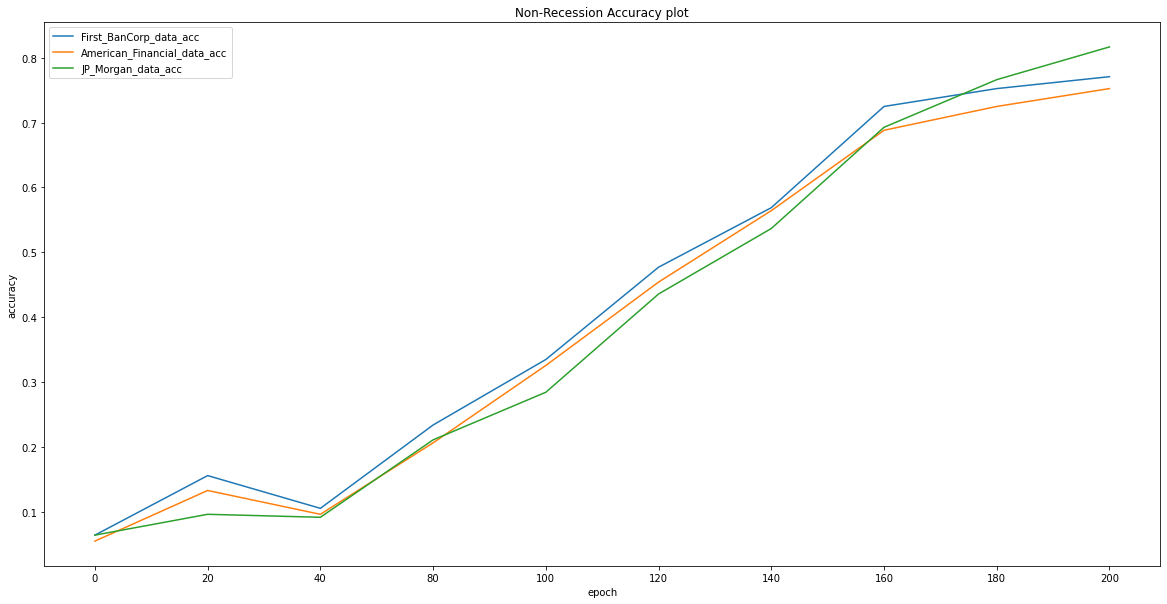

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

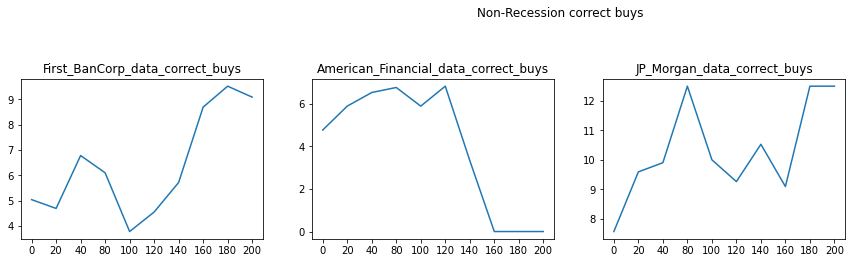

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

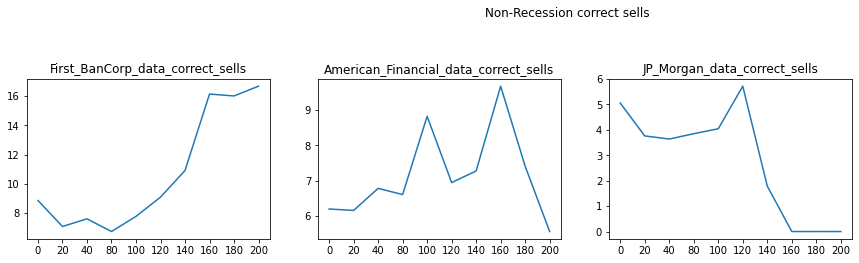

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

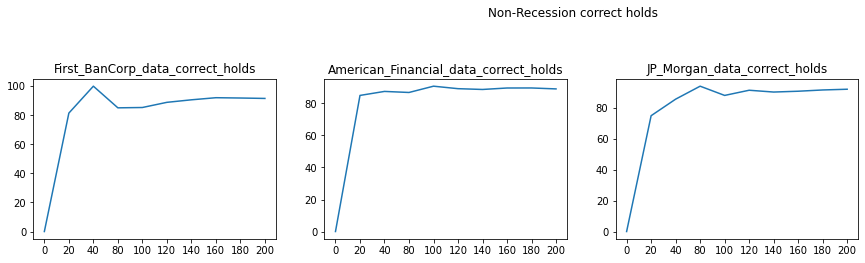

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

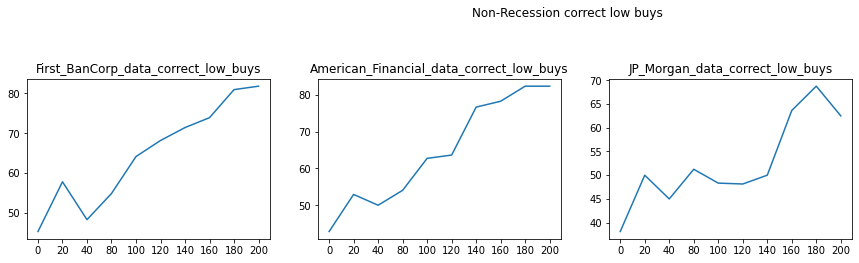

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

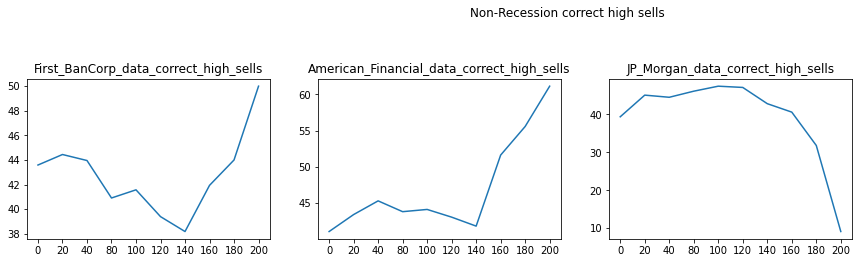

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

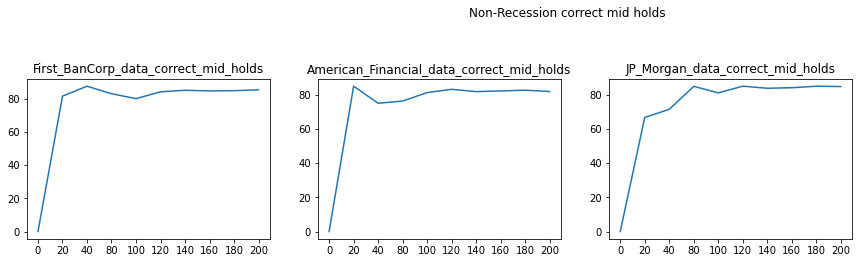

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

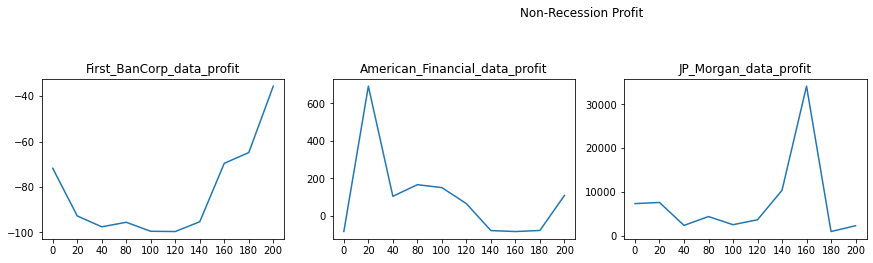

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [93]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


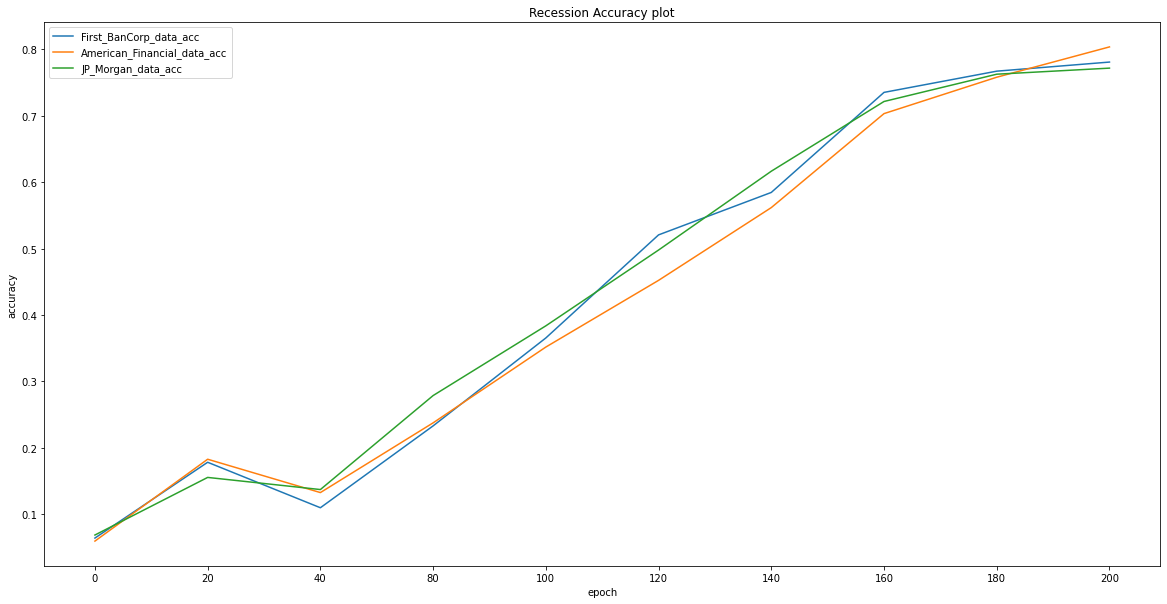

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

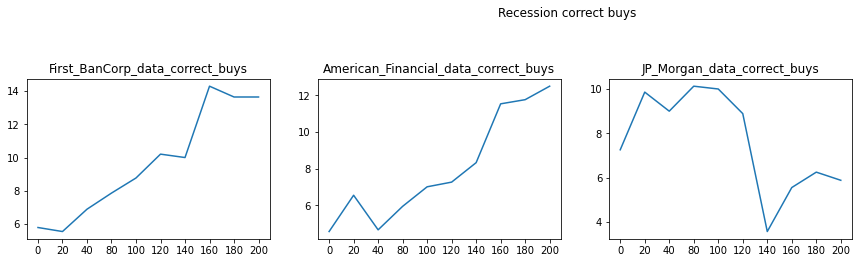

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

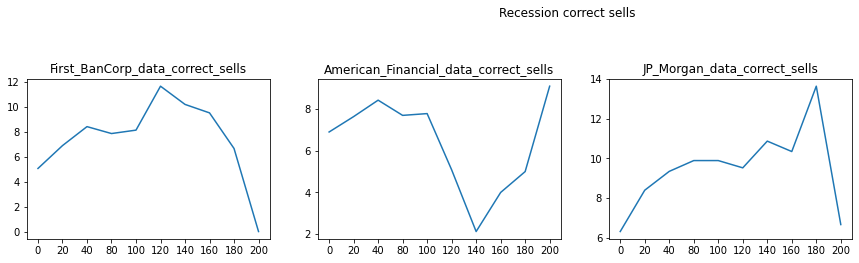

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

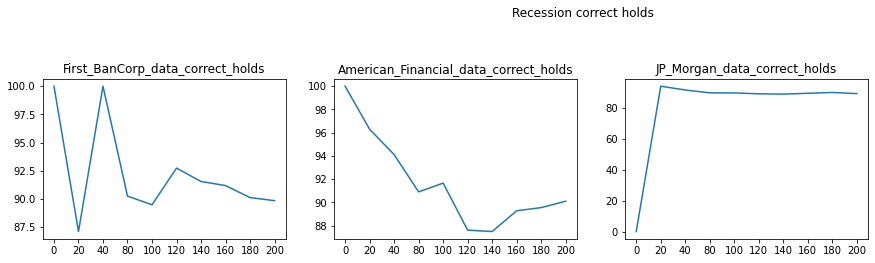

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

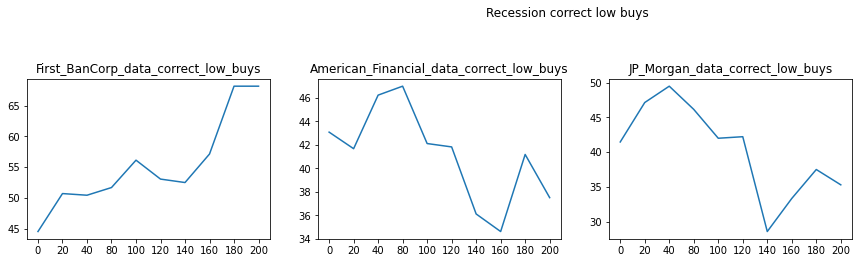

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

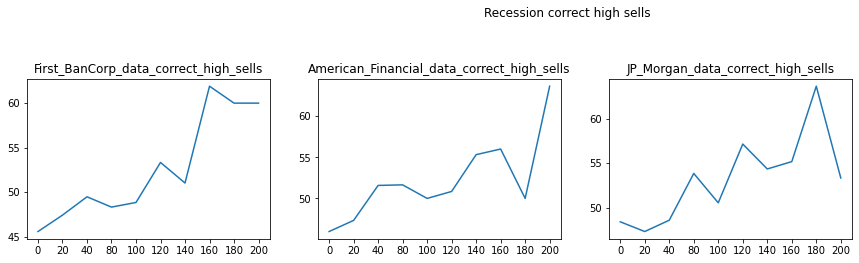

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

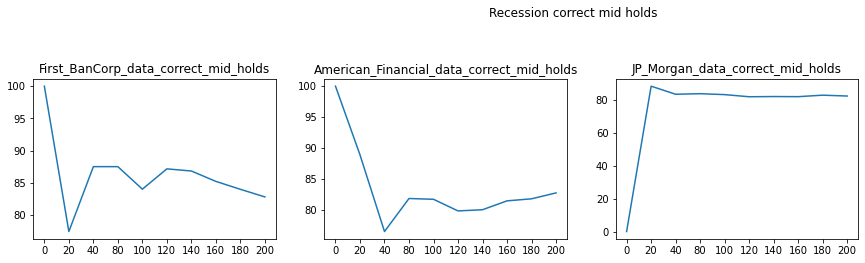

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

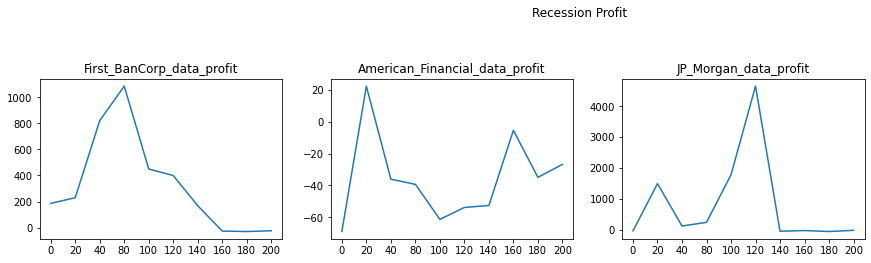

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")